## **Import the useful packages** 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import matplotlib.patches as pac

import cartopy.crs as ccrs
import xarray as xr

import pandas as pd
from functions import ticks_labels, plot_monthly_trend, regression_analysis, twosigfig

## **Set filepaths for the useful data**

In [2]:
fp_data = 'Figure_data/'
fp_figures = 'FIGURES/'

## **Figure 1**

**The spatial distribution of ice-shelf cavities which are resolved in the NEMO model at 0.25◦ and 1◦.** Panel a) shows the
distribution of cavities resolved at 0.25◦ (dark and light blue) and 1.0◦ (light blue only) simulations for the whole Antarctic continent,
illustrating that although the largest ice shelves are resolved in the 1.0◦ model, many important and fast-changing regions require a higher
resolution for sub-ice shelf dynamics to be included in ocean models. Panels b) and c) show zoomed-in insets for the Amundsen Sea sector
and Amery Ice Shelf as examples. We use the regions which are only resolved in the 0.25◦ simulations (dark blue) for training the neural
network.

In [3]:
# For plotting things on the polar stereographic grid with lat and lon coordinates 
proj=ccrs.SouthPolarStereo(central_longitude=0.0)
trans=ccrs.PlateCarree()

In [4]:
import glob
glob.glob(fp_data + '*.nc')

['Figure_data/basin_raster_extrapolate_eANT025.nc',
 'Figure_data/domain_cfg_eANT025.L121.nc',
 'Figure_data/domain_cfg_eANT025.L121_REDUCED_CAV.nc']

In [5]:
# Load in the data specifically needed here
ds0=xr.open_dataset(fp_data + 'basin_raster_extrapolate_eANT025.nc')
dsREF=xr.open_dataset(fp_data + 'domain_cfg_eANT025.L121.nc')
dsREDCAV=xr.open_dataset(fp_data + 'domain_cfg_eANT025.L121_REDUCED_CAV.nc')
dsREF = dsREF.squeeze('time_counter')
dsREDCAV = dsREDCAV.squeeze('time_counter')
Nbasin=ds0.basin.max()
# Create masks for the ocean and closed cavities 
ocean=xr.where(((dsREF.top_level>0.5)&(dsREF.top_level<1.5)),1,np.nan)
not_ocean = xr.where(((dsREF.top_level>0.5)&(dsREF.top_level<1.5)),np.nan,1)
isfREF=xr.where((dsREF.top_level>1.5),1,np.nan)
closed=xr.where(((dsREF.top_level>1.5)&(dsREDCAV.top_level<0.5)),1,np.nan)
lon2d=dsREF.glamt.values
lat2d=dsREF.gphit.values
# to avoid hexagons in cartopy:
lon2d[lon2d>=180] = lon2d[lon2d>=180.] - 360.
delta_lon=np.abs(np.diff(lon2d))
for i, start in enumerate(np.argmax(delta_lon > 180, axis=1)):
  lon2d[i, start+1:] += 360


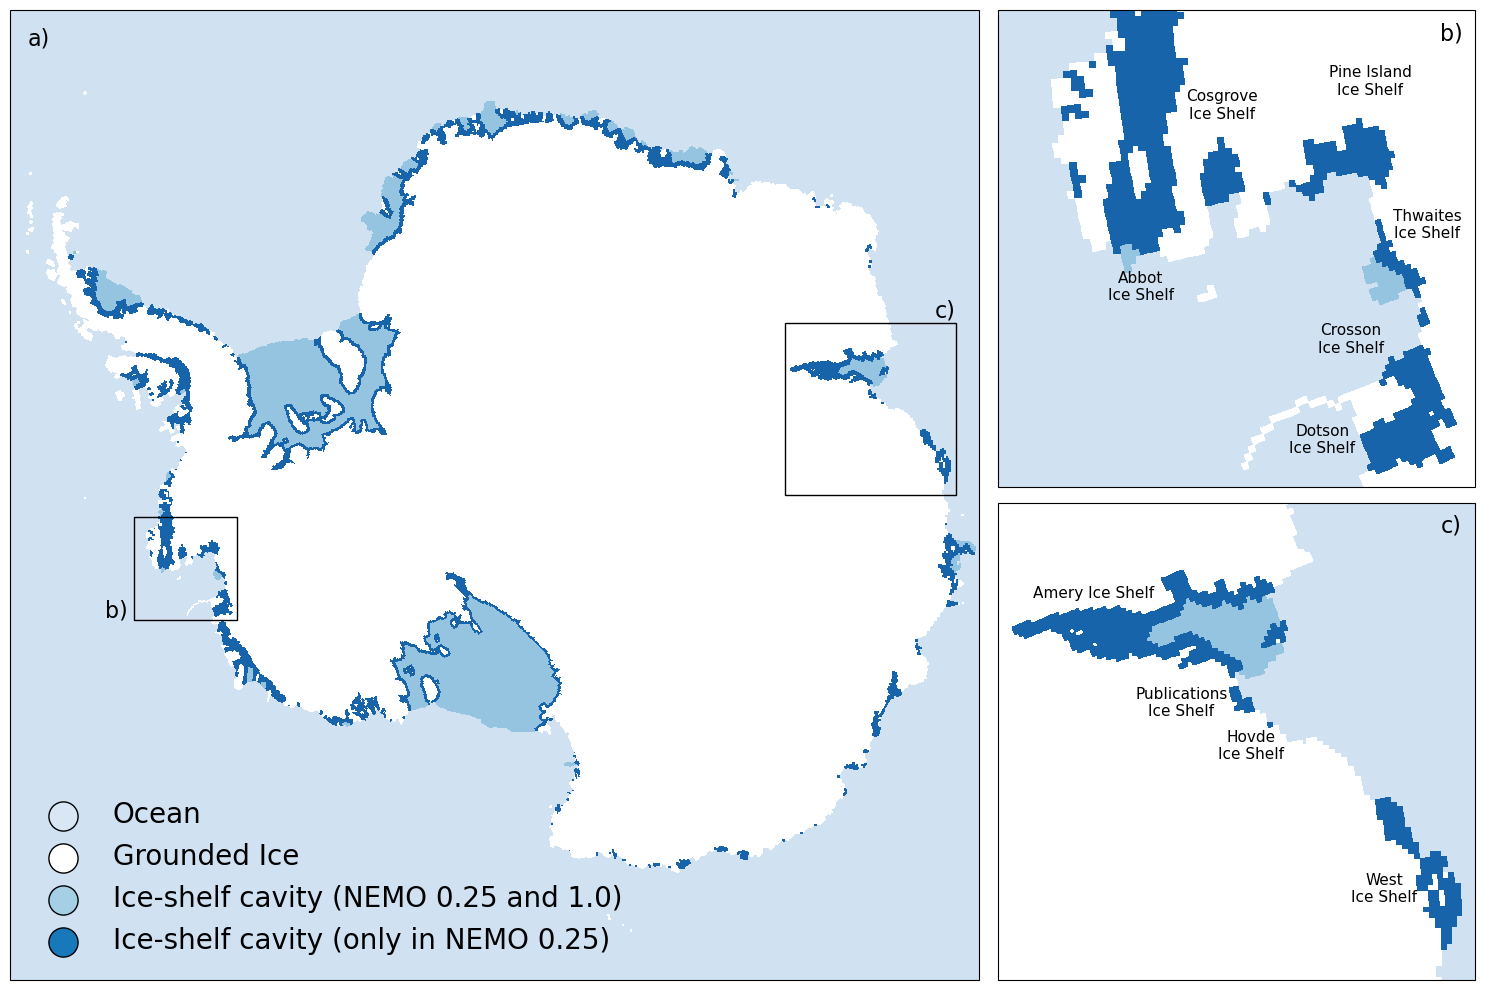

In [6]:
fig = plt.figure(figsize=(15, 10))
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1])  # Two columns, first is twice as wide

ax = [[],[],[]]
ax[0] = fig.add_subplot(gs[:,0], projection = proj)
ax[1] = fig.add_subplot(gs[0,1], projection = proj)
ax[2] = fig.add_subplot(gs[1,1], projection = proj)

ax[0].set_extent( (-180, 180, -88, -65), trans )
ax[1].set_xlim(-2.1e6,-1.5e6)
ax[1].set_ylim(-0.73e6,-0.13e6)
ax[2].set_xlim(1.7e6,2.7e6)
ax[2].set_ylim(-0e6,1e6)

plt.tight_layout()

kw_blue={'vmin': 0.5, 'vmax': 3.0, 'cmap': 'Blues_r'}
kw_white={'vmin': 1.0, 'vmax': 3.0, 'cmap': 'Greys'}
kw_lightblue = {'vmin':0.2, 'vmax': 2.2, 'cmap': 'Blues'}
kw_superlightblue = {'vmin':0.6, 'vmax': 2.6, 'cmap': 'Blues'}
kw_otherblue = {'vmin': -1, 'vmax': 5.0, 'cmap': 'Blues_r'}

for i in range(3):
    ax[i].pcolormesh(lon2d,lat2d,ocean, rasterized=True, transform=trans, **kw_superlightblue)
    ax[i].pcolormesh(lon2d, lat2d, not_ocean, rasterized=True, transform=trans, **kw_white )
    ax[i].pcolormesh(lon2d, lat2d, isfREF   , rasterized=True, transform=trans, **kw_lightblue )
    ax[i].pcolormesh(lon2d, lat2d, closed   , rasterized=True, transform=trans, **kw_blue )

ax[0].scatter(2e7,200, color = '#D9E7F5', label = 'Ocean')
ax[0].scatter(-2e7,200, color = 'white', label = 'Grounded Ice')
ax[0].scatter(2e7,200, color = '#A4CFE5', label = 'Ice-shelf cavity (NEMO 0.25 and 1.0)')
ax[0].scatter(2e7,200, color = '#1879BA', label = 'Ice-shelf cavity (only in NEMO 0.25)')
leg = ax[0].legend(ncol = 1, loc = 'lower left', fontsize = 20, markerscale = 3.5, framealpha = 0)
for ha in leg.legend_handles:
    ha.set_edgecolor("k")

rectangle = pac.Rectangle((-2.1e6,-0.73e6), 0.6e6, 0.6e6, fc='none',ec="k")
rectangle2 = pac.Rectangle((1.7e6,-0e6), 1.0e6, 1.0e6, fc='none',ec="k")
ax[0].add_patch(rectangle)
ax[0].add_patch(rectangle2)

kw_annotate = {'xycoords':'axes fraction','va':'center','ha':'center','xy':(0.5,0.5),'fontsize':11}
kw_annotate0 = {'xycoords':'axes fraction','va':'center','ha':'center','xy':(0.5,0.5),'fontsize':16}
ax[2].annotate(text = 'Amery Ice Shelf', xytext = (0.2, 0.81), **kw_annotate)
ax[2].annotate(text = 'Publications\nIce Shelf', xytext = (0.385, 0.58), **kw_annotate)
ax[2].annotate(text = 'Hovde\nIce Shelf', xytext = (0.53, 0.49), **kw_annotate)
ax[2].annotate(text = 'West\nIce Shelf', xytext = (0.81, 0.19), **kw_annotate)

ax[1].annotate(text = 'Abbot\nIce Shelf', xytext = (0.3, 0.42), **kw_annotate)
ax[1].annotate(text = 'Cosgrove\nIce Shelf', xytext = (0.47, 0.80), **kw_annotate)
ax[1].annotate(text = 'Pine Island\nIce Shelf', xytext = (0.78, 0.85), **kw_annotate)
ax[1].annotate(text = 'Thwaites\nIce Shelf', xytext = (0.9, 0.55), **kw_annotate)
ax[1].annotate(text = 'Crosson\nIce Shelf', xytext = (0.74, 0.31), **kw_annotate)
ax[1].annotate(text = 'Dotson\nIce Shelf', xytext = (0.68, 0.1), **kw_annotate)

ax[0].annotate(text = 'b)', xytext = (0.11, 0.38), **kw_annotate0)
ax[0].annotate(text = 'c)', xytext = (0.965, 0.69), **kw_annotate0)
ax[0].annotate(text = 'a)', xytext = (0.03, 0.97), **kw_annotate0)
ax[1].annotate(text = 'b)', xytext = (0.95, 0.95), **kw_annotate0)
ax[2].annotate(text = 'c)', xytext = (0.95, 0.95), **kw_annotate0)

plt.show()
fig.savefig(fp_figures+ 'F1_Resolved_regions.jpg', dpi = 200, bbox_inches = 'tight')

## **Figure 2**
**A schematic showing the key inputs and outputs involved in the neural network training and application**. Water properties
and cavity geometry are separate classes of input properties because water properties come from the edge of the cavity as resolved in the
1◦ ocean model, and cavity geometry comes from the region which is not resolved in the 1◦ ocean model. In training, cavity geometry is
provided by the NEMO◦ model, but in a coupled ocean-ice-sheet models the geometry would come from the ice-sheet model.

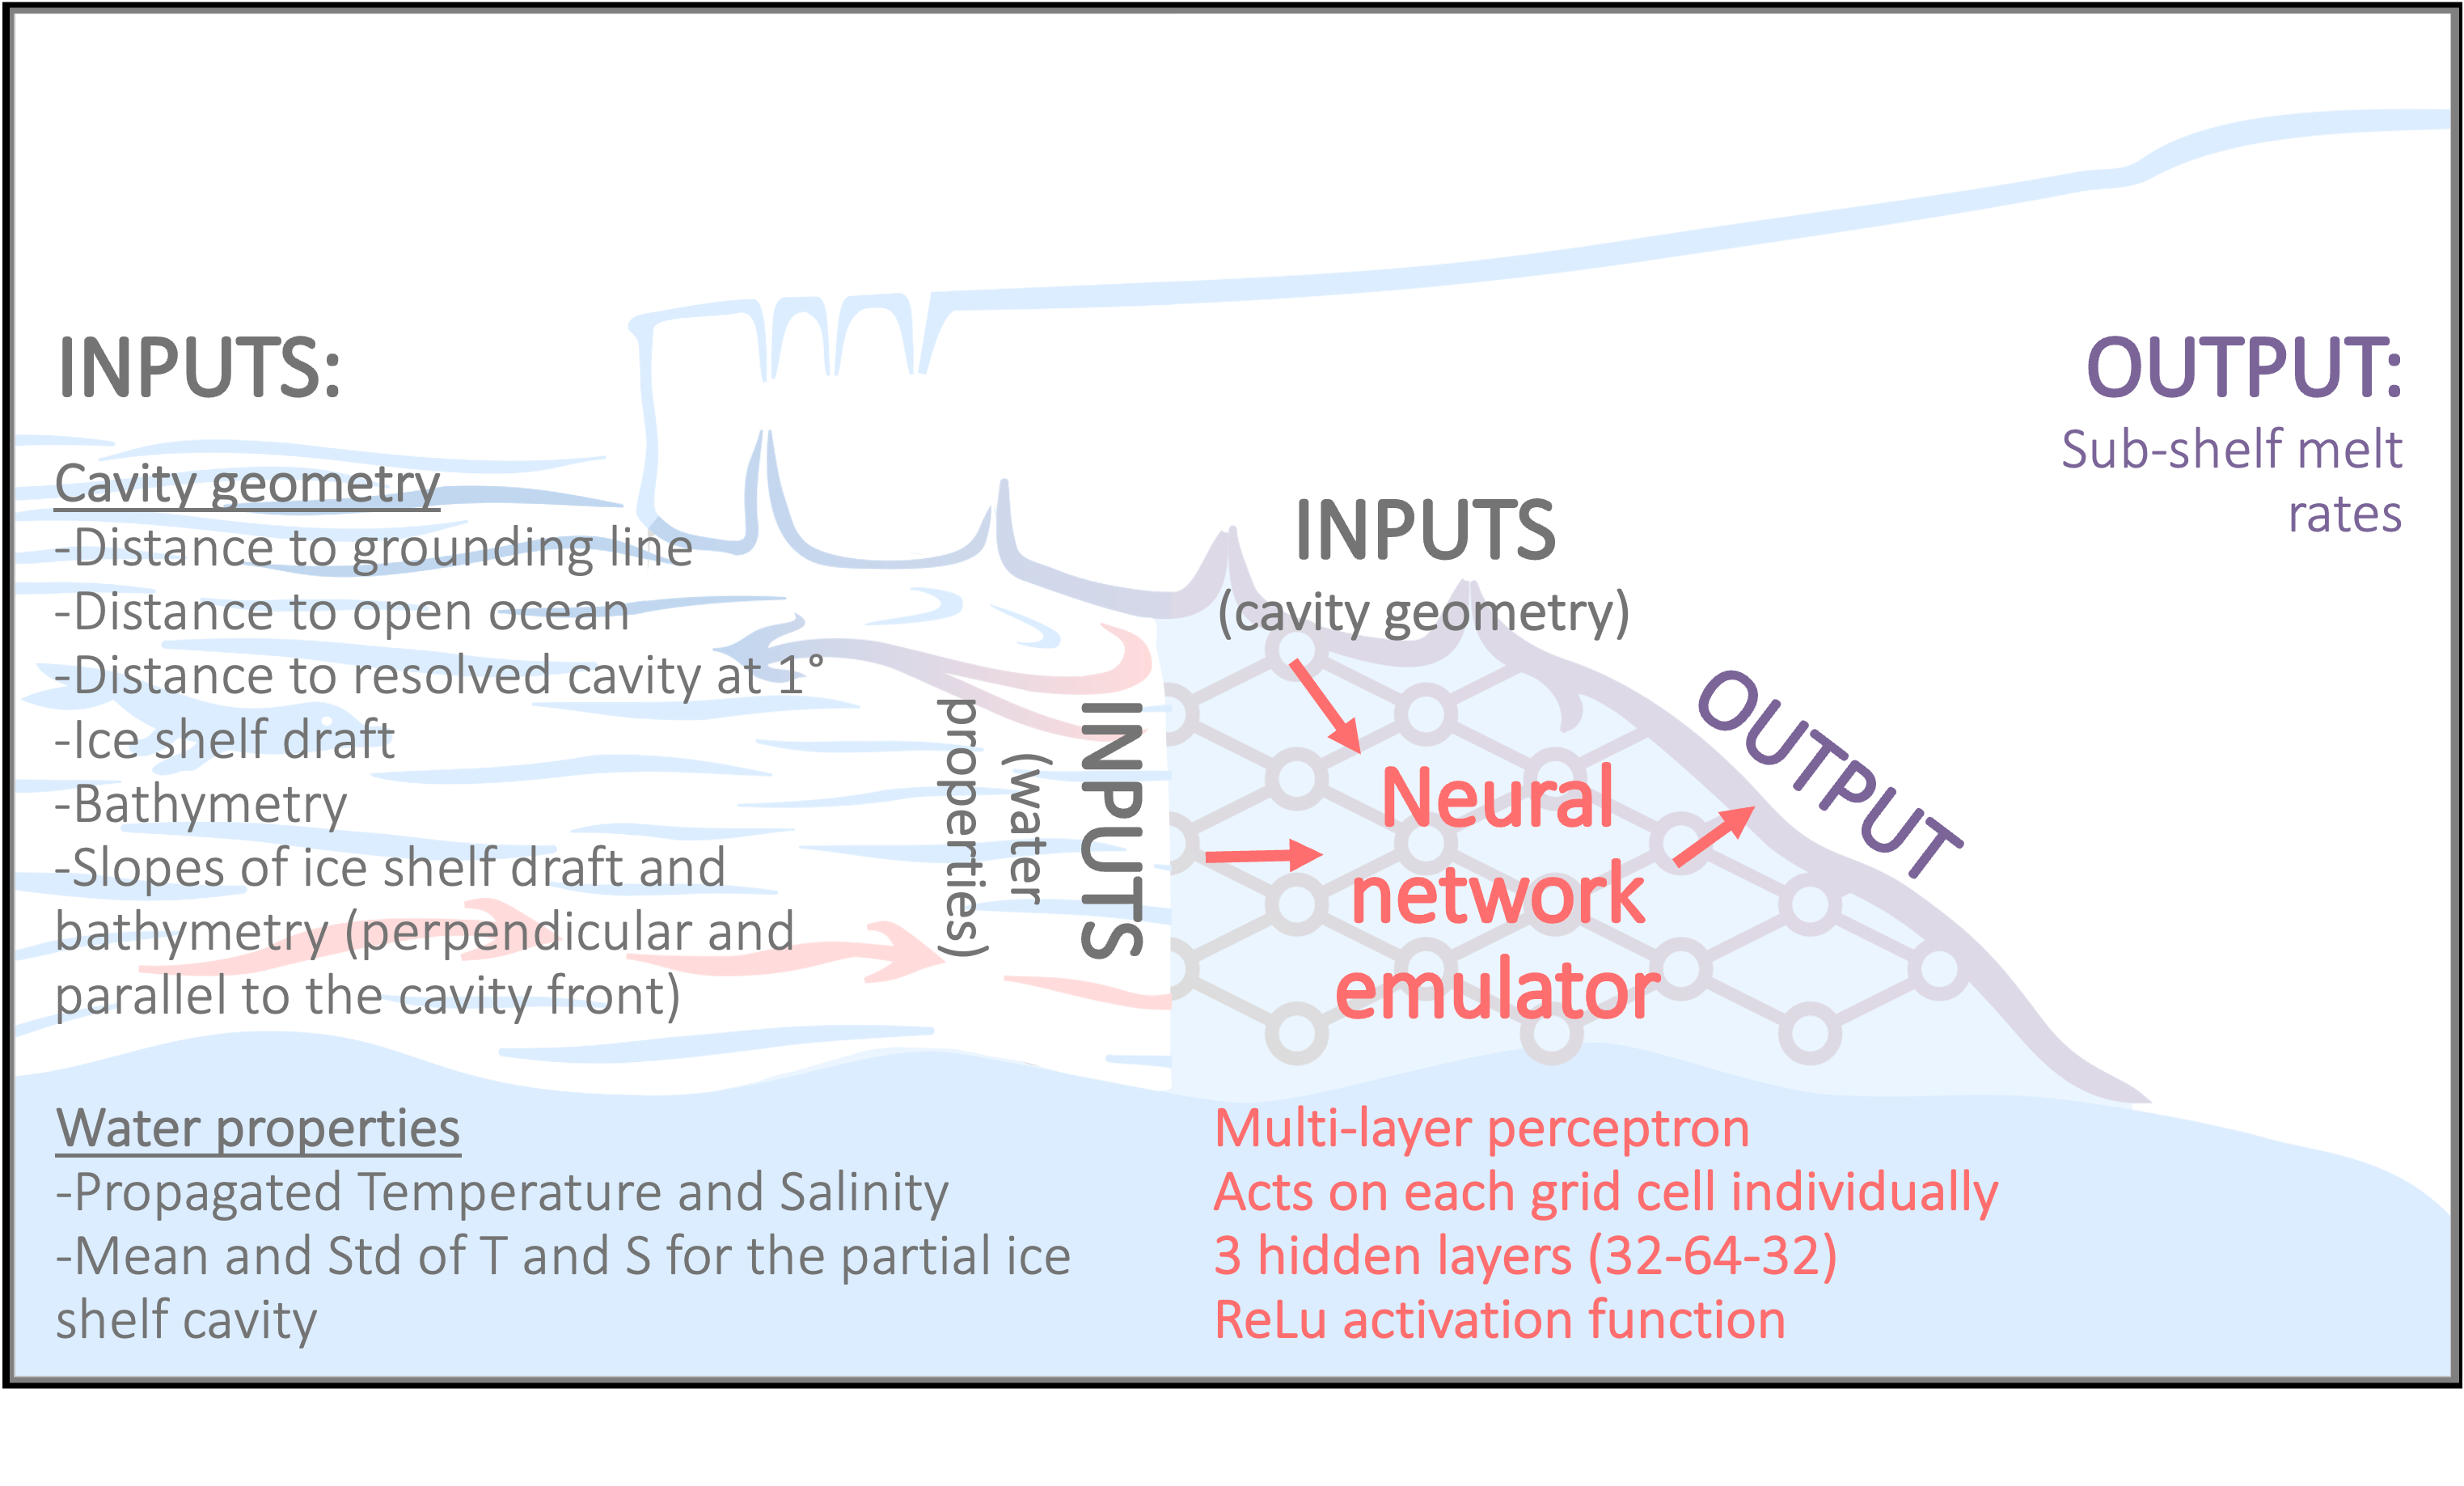

In [7]:
from IPython.display import Image
Image(fp_data + 'NN training process.png')

## **Figure 3**
**Neural network performance in temperature conditions outside the training dataset.** The reference melt rates from the
ANT2100 simulation (grey), compared to the predicted melt rates from neural networks trained on monthly data from the ANT2000 (blue)
and ANT2300 (red) simulations. Melt rates are integrated melt rates for the whole of Antarctica in Gt/yr. The ensemble spread of the 10
neural networks is shown through the error bounds which represent the standard deviation.

In [8]:
df_mn26_trim = pd.read_csv(fp_data+ 'df_mn26_trim.csv')
df_mn31_trim = pd.read_csv(fp_data+ 'df_mn31_trim.csv')

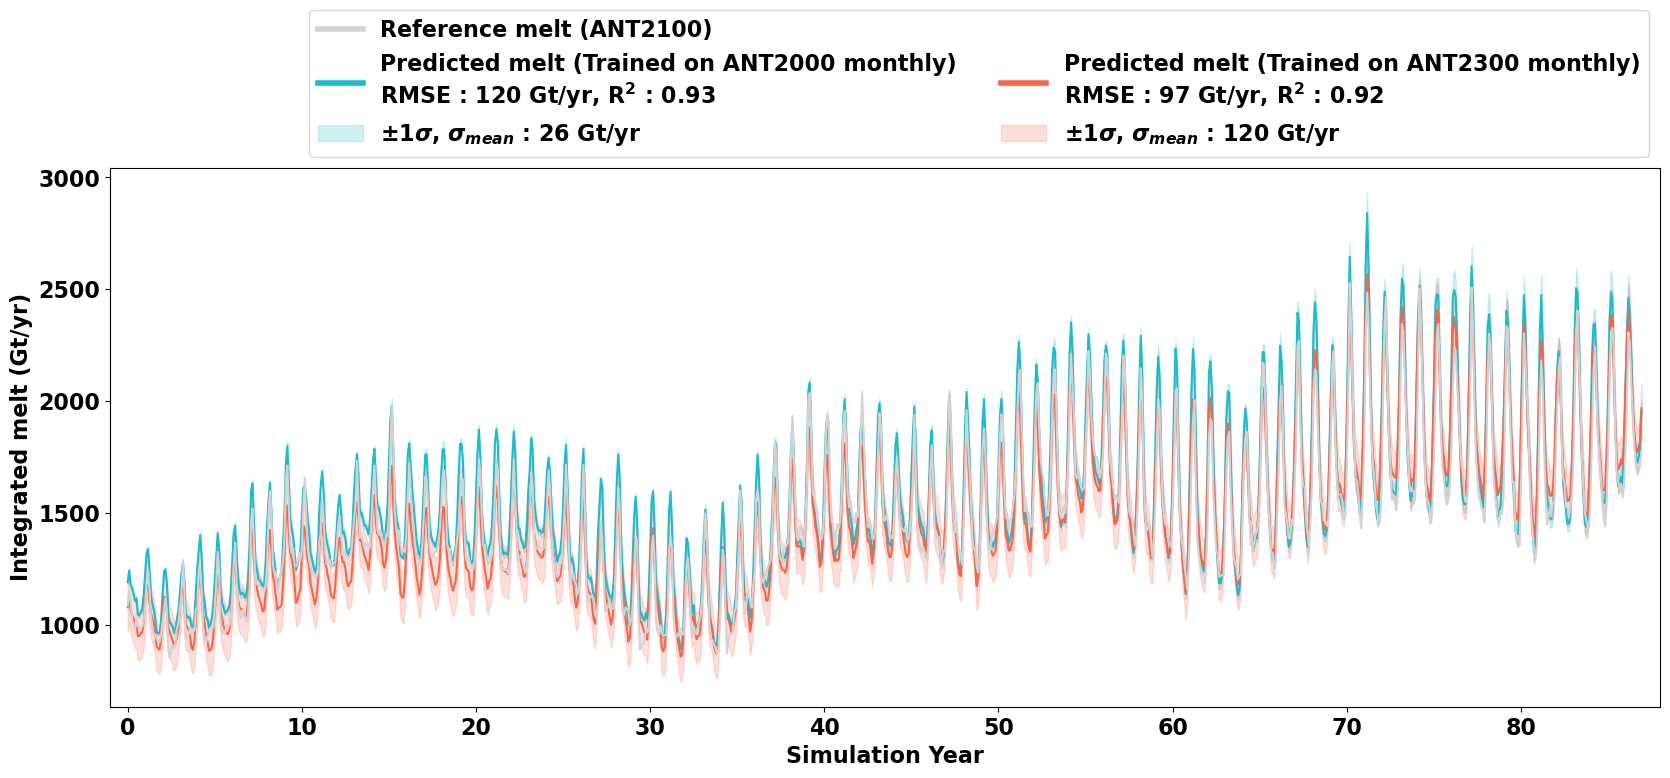

In [9]:
with plt.rc_context({'font.size': 16, 'font.weight': 'bold', 'axes.labelsize': 16, 'axes.labelweight': 'bold'}):
    fig, axs = plt.subplots(1,1, figsize = (20,7))
    fig.subplots_adjust(wspace=0, hspace = 0.7)

    ax = axs
    df_z = df_mn26_trim
    ticks, labels = ticks_labels(df_z)    
    ax.plot(df_z.year + df_z.month/12, df_z.melt_Gt_per_y, color = 'lightgrey', label = 'Reference melt (ANT2100)', zorder = 10)
    plot_monthly_trend(df_mn26_trim, 'C9', label = 'Predicted melt (Trained on ANT2000 monthly)', \
                       std = True, label_std = '$\\pm1\\sigma$', flip = 'second', ax = ax)
    ax.scatter((1), (800), color = 'white', \
               label = " ")
    plot_monthly_trend(df_mn31_trim, 'tomato', label = 'Predicted melt (Trained on ANT2300 monthly)', \
                       std = True, label_std = '$\\pm1\\sigma$', flip = 'second', ax = ax)
    ax.set_xlim(np.min(np.unique(df_z.year))-1, np.max(np.unique(df_z.year))+2)
    ax.set_xticks(ticks, labels)
    

    ax.set_xlabel('Simulation Year', fontsize = 16)
    ax.set_ylabel('Integrated melt (Gt/yr)', fontsize = 16)
    leg = ax.legend(fontsize = 16, loc = 'lower right', bbox_to_anchor = [0,1,1,2], ncols = 2)
    for line in leg.get_lines():
        line.set_linewidth(4.0)
    
    plt.show()
    fig.savefig(fp_figures + 'F3_Outside_temp_conditions.pdf', bbox_inches = 'tight')

## **Figure 4**
Neural network performance in temperature conditions outside the training dataset and in each of the IMBIE glacial
drainage basins. A comparison of the reference melt rate from the ANT2300 simulation (grey) with the predicted melt rate from neural
networks trained on monthly data from ANT2000 (blue) and ANT2100 (peach) to each glacial drainage basin in the ANT2300 simulation.
a) Integrated melt rates for the whole of Antarctica. b-s) Integrated melt rates for each of the IMBIE glacial drainage basins. The location of each basin is shown in the central inset map.

In [10]:
latlonbasin = pd.read_csv(fp_data+ 'latlonbasin.csv')
df_26_ymb = pd.read_csv(fp_data+ 'df_26_ymb.csv')
df_Ch_ymb = pd.read_csv(fp_data+ 'df_Ch_ymb.csv')
df_2_trim = pd.read_csv(fp_data+ 'df_2_trim.csv')
df_c_trim = pd.read_csv(fp_data+ 'df_c_trim.csv')

In [11]:
colors = ['deeppink', 'tomato', 'firebrick', 'darkorange']
regions = [[2,153,3,6,7,4],\
           [8,9,12,11,14,13,15],\
           [16,17,18,19,128,22],\
           [103,154],\
           [21,23,24,25,26,27,28],\
           [29,30,31,32,33,34,35,36,37,38],\
           [40,41,42,43,44],\
           [45,97,94,95,69,70,89,88,92,93,91,90,87,46,47],\
           [136,137,62,68,67,66,65,64,63,61,60,59],\
           [57,58,71,72,73,138,140,139,81,80,79,78,104],\
           [105,49,132,141,108,142],\
           [129,101,51,50,107,130,52,143],\
           [144,145,146,110,55,56,133,134],\
           [111,125,124,127,126,100],\
           [113,122,115,116],\
           [147,119,117,77,118],\
           [120,76,75,74,86,99,98,85,150,149,148,155],\
           [1,84,121,83,82,135,152,151]]

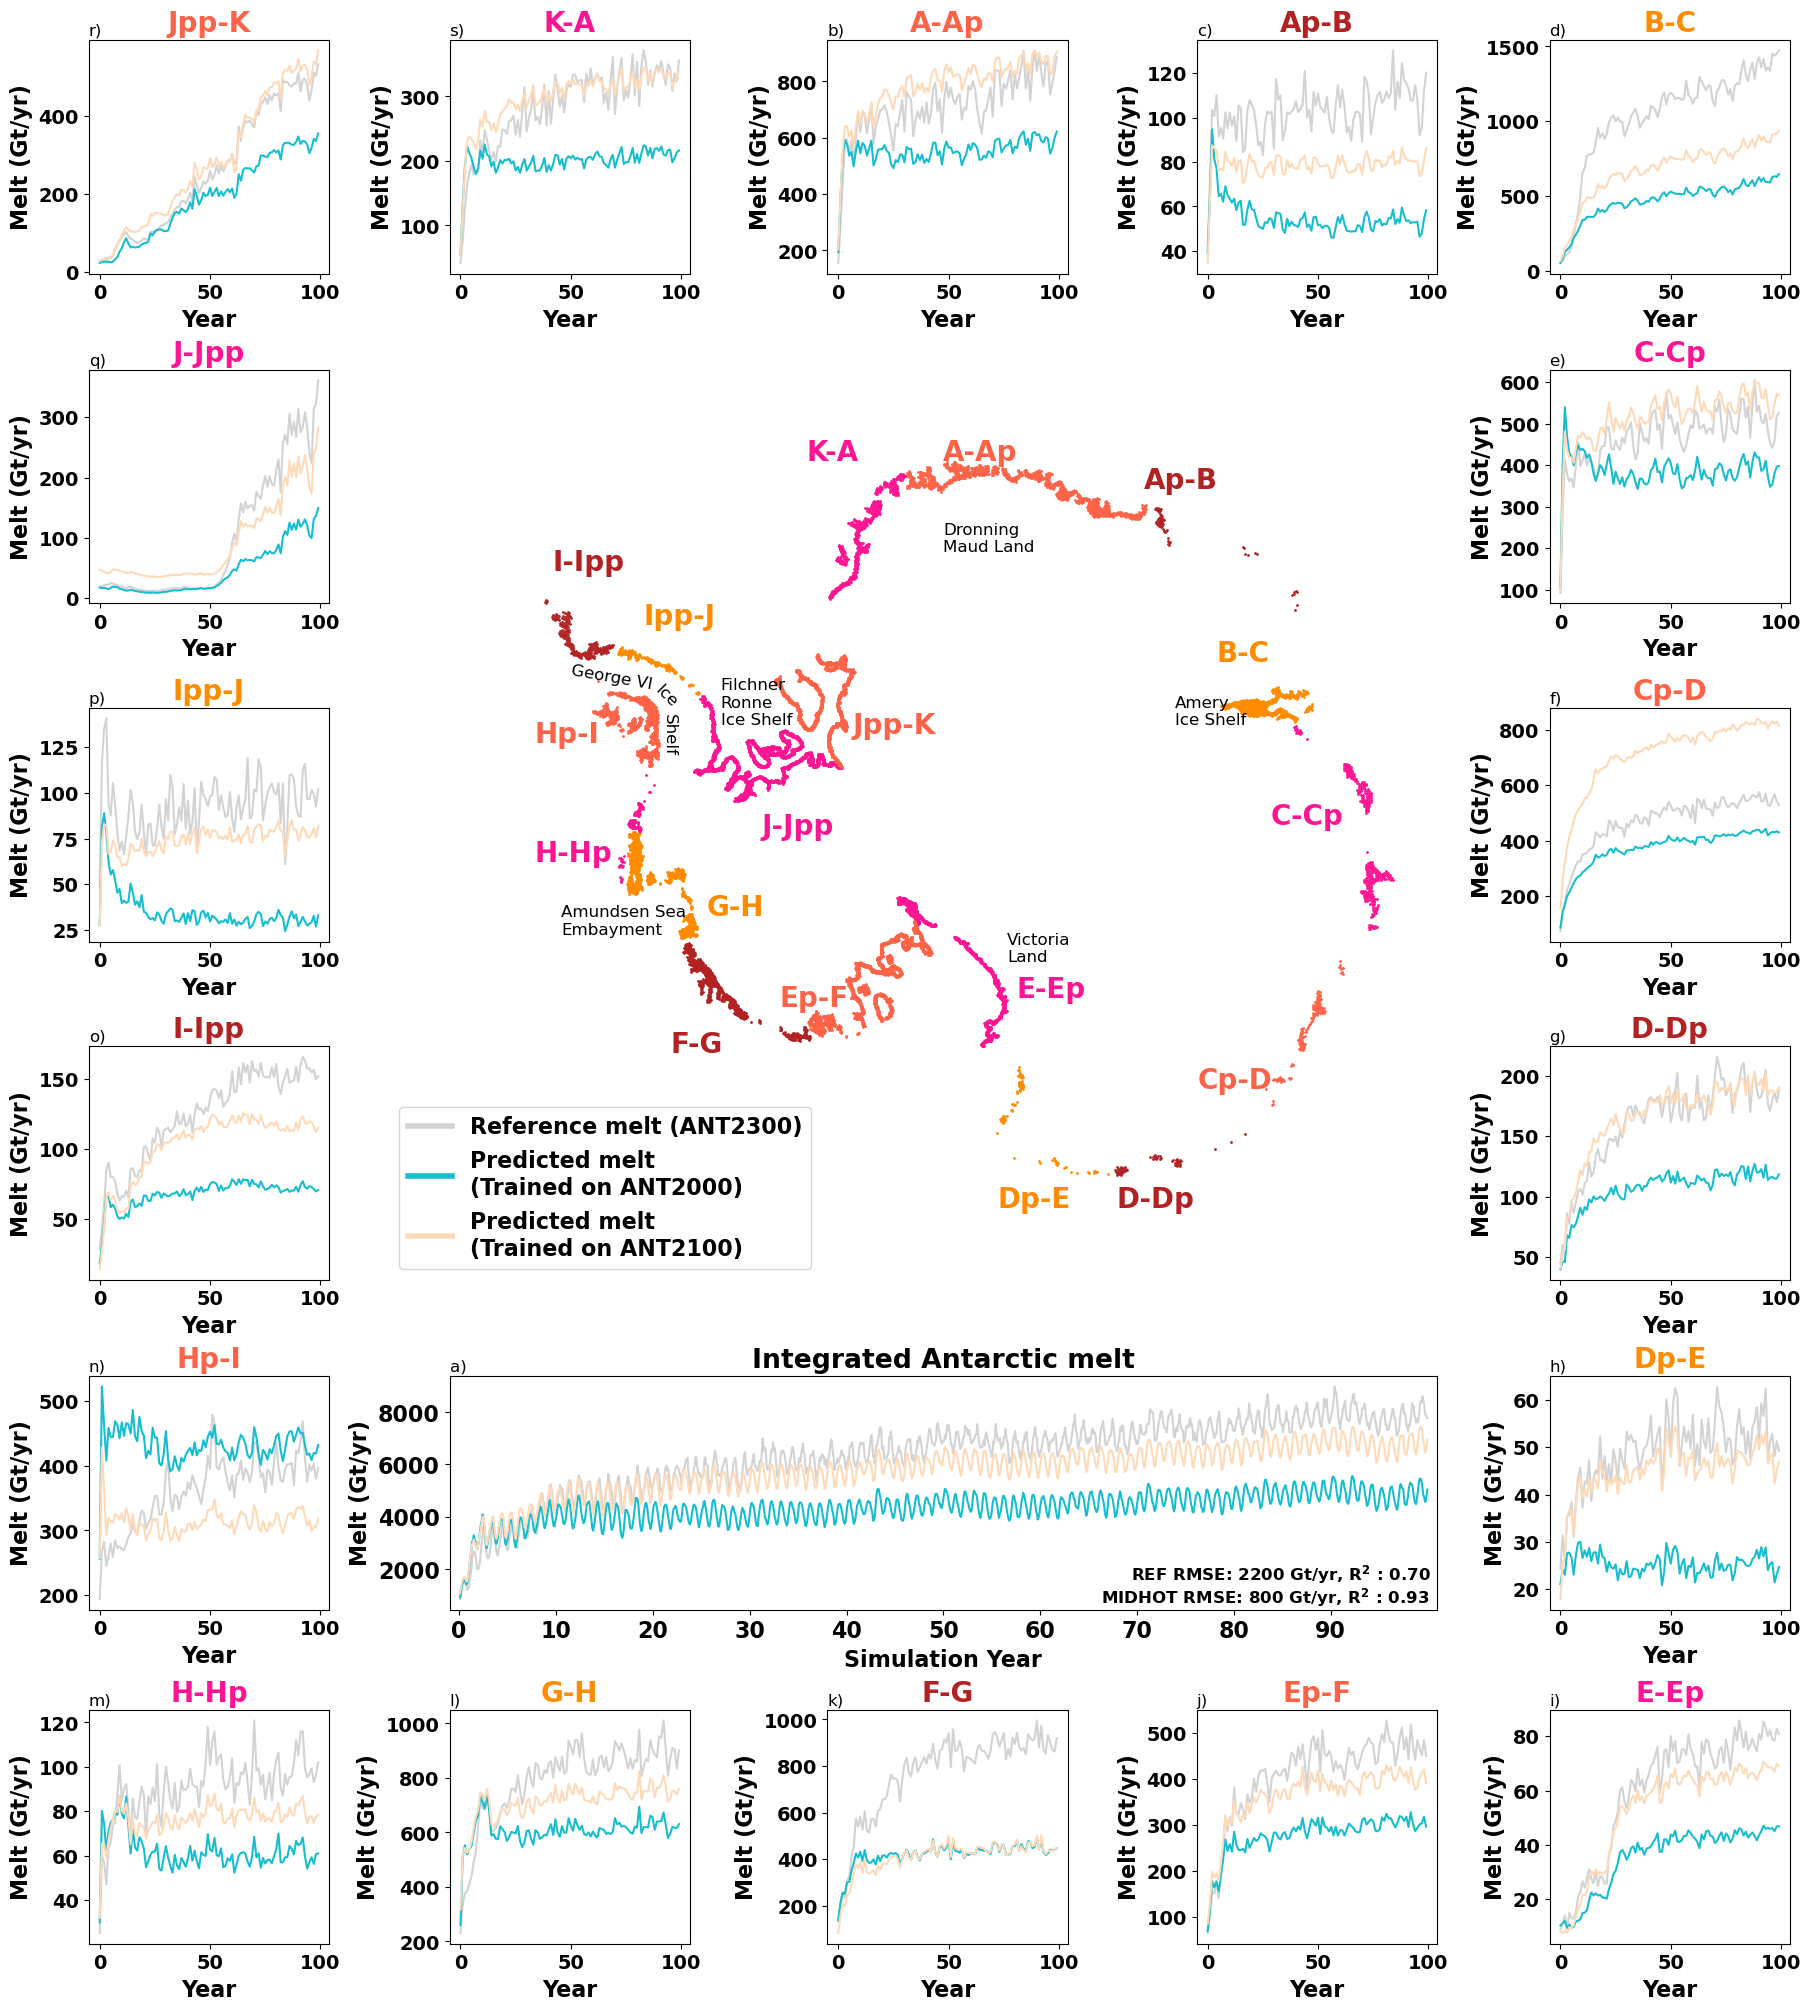

In [12]:
with plt.rc_context({'font.size': 16, 'font.weight': 'bold', 'axes.labelsize': 16, 'axes.labelweight': 'bold'}):
    axs = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
    fig = plt.figure(constrained_layout=True, figsize = (18,20))
    widths = [4,4,4,4,4]
    heights = [4,4,4,4,4,4]
    gs = fig.add_gridspec(6,5, width_ratios = widths, height_ratios = heights)
    #for i,j in itertools.product(range(6),range(5)):
    #    fig.add_subplot(gs[i,j])
    
    titles = ['K-A', 'A-Ap', 'Ap-B', 'B-C', 'C-Cp',\
              'Cp-D','D-Dp','Dp-E', 'E-Ep', 'Ep-F', \
              'F-G', 'G-H', 'H-Hp', 'Hp-I', 'I-Ipp', \
              'Ipp-J', 'J-Jpp', 'Jpp-K']
    coords = [(0.35,0.9), (0.5,0.9), (0.72,0.87), (0.8,0.68), (0.86,0.5),\
              (0.78,0.21), (0.69,0.08), (0.56,0.08), (0.58,0.31), (0.32,0.3), (0.2,0.25),\
              (0.24,0.4), (0.05,0.46), (0.05,0.59), (0.07,0.78), (0.17,0.72),\
              (0.3,0.49), (0.4,0.60)]
    
    axs[17] = fig.add_subplot(gs[1:4,1:4], projection= proj)
    axs[17].set_extent( (-180, 180, -88, -65), trans )
    for i in range(len(regions)):
        for j in range(len(regions[i])):
            basin = latlonbasin[latlonbasin.basin == regions[i][j]]
            im = axs[17].scatter(basin.lon, basin.lat, c = colors[np.mod(i,4)], \
                       transform = trans, s= 1)    
        axs[17].annotate(titles[i], xy = (0,0), xytext = (coords[i]), xycoords = 'axes fraction', transform = trans, \
                       fontsize = 20, color = colors[np.mod(i,4)])
    axs[17].annotate('Dronning\nMaud Land', xy = (1,0), xytext = (0.5,0.8), xycoords = 'axes fraction', \
                     fontsize = 12, fontweight = 'light')
    axs[17].annotate('Victoria\nLand', xy = (1,0), xytext = (0.57,0.35), xycoords = 'axes fraction', \
                     fontsize = 12, fontweight = 'light')
    axs[17].annotate('George VI', xy = (1,0), xytext = (0.09,0.65), xycoords = 'axes fraction', \
                     fontsize = 12, fontweight = 'light', rotation = -10)
    axs[17].annotate('Ice', xy = (1,0), xytext = (0.18,0.63), xycoords = 'axes fraction', \
                     fontsize = 12, fontweight = 'light', rotation = -45)
    axs[17].annotate('Shelf', xy = (1,0), xytext = (0.19,0.58), xycoords = 'axes fraction', \
                     fontsize = 12, fontweight = 'light', rotation = -90)
    axs[17].annotate('Filchner\nRonne\nIce Shelf', xy = (1,0), xytext = (0.255,0.61), xycoords = 'axes fraction', \
                     fontsize = 12, fontweight = 'light')
    axs[17].annotate('Amery\nIce Shelf', xy = (1,0), xytext = (0.755,0.61), xycoords = 'axes fraction', \
                     fontsize = 12, fontweight = 'light')
    axs[17].annotate('Amundsen Sea\nEmbayment', xy = (1,0), xytext = (0.08,0.38), xycoords = 'axes fraction', \
                     fontsize = 12, fontweight = 'light')
    
    axs[17].axis('off')

    plot_i = [0,0,0,0,1,2,3,4,5,5,5,5,5,4,3,2,1,0]
    plot_j = [1,2,3,4,4,4,4,4,4,3,2,1,0,0,0,0,0,0]
    xytexts = [(0.4,0.8), (0.4,0.8), (0.03,0.03), (0.4,0.03), (0.03,0.8), (0.03,0.8), 
               (0.4,0.8), (0.03,0.8), (0.03,0.8), (0.03,0.8), (0.03,0.03), (0.4,0.8),  
               (0.4,0.8), (0.03,0.8), (0.4,0.8), (0.03,0.8), (0.4,0.8), (0.4,0.8)]
    plt_labels = ['s)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)', 'l)', 'm)', 'n)', 'o)', 'p)', 'q)', 'r)'] 
    for i in range(18):
        axs[i] = fig.add_subplot(gs[plot_i[i], plot_j[i]])

    bym = df_26_ymb
    for i in range(18):
        mask = np.in1d(bym.basin, regions[i])
        bym2 = bym[mask].groupby(['year'], as_index = False).sum()
        axs[i].plot(bym2.year-np.min(bym2.year), -bym2.melt_Gt_per_y/12, color = 'lightgrey')
        axs[i].plot(bym2.year-np.min(bym2.year), -bym2.melt_pred_Gt/12, color = 'C9')
        axs[i].set_title(titles[i], fontsize = 20, fontweight = 'bold', color = colors[np.mod(i,4)])
        axs[i].tick_params(axis='both', which='major', labelsize=14)

    bym = df_Ch_ymb
    for i in range(18):
        mask = np.in1d(bym.basin, regions[i])
        bym2 = bym[mask].groupby(['year'], as_index = False).sum()
        axs[i].plot(bym2.year-np.min(bym2.year), bym2.melt_pred_Gt/12, color = 'peachpuff')
        #RMSE = twosigfig(RMSE)
        axs[i].set_xlabel('Year')
        axs[i].set_ylabel('Melt (Gt/yr)')
    #    axs[i].set_xticks((0,10,20,30))
    #    axs[i].annotate('RMSE: {} Gt/yr\nR$^2$ : {:.2f}'.format(RMSE, R2), xytext = xytexts[i], xy = (0,0), \
    #                    xycoords = 'axes fraction', fontsize = 12)
        label = plt_labels[i]
        axs[i].annotate(label, xytext = (0,1.02), xy = (0,0), \
                        xycoords = 'axes fraction', fontsize = 12, fontweight = 'normal')

    axs[18] = fig.add_subplot(gs[4,1:4])
    axs[18].set_title('Integrated Antarctic melt', fontweight = 'bold')
    axs[18].set_xlabel('Year')
    axs[18].set_ylabel('Melt (Gt/yr)')

    

    
    df_z = df_2_trim
    ticks, labels = ticks_labels(df_z)    
    ax = axs[18]
    ax.plot(df_z.year + df_z.month/12, -df_z.melt_Gt_per_y, color = 'lightgrey', label = 'Reference melt (HOT2300)', zorder = 0)
    plot_monthly_trend(df_z, 'C9', label = 'Predicted melt\n(Trained on REF annual)', ax = ax, \
                       std = False, label_std = '$\\pm1\\sigma$')
    RMSE = np.sqrt(np.mean((df_z.melt_Gt_per_y- df_z.melt_pred_Gt)**2))
    R2 = regression_analysis(df_z.melt_Gt_per_y,df_z.melt_pred_Gt)[2]
    RMSE = twosigfig(RMSE)
    ax.annotate('REF RMSE: {} Gt/yr, R$^2$ : {:.2f}'.format(RMSE, R2), xytext = (0.69,0.13), xy = (0,0), \
                        xycoords = 'axes fraction', fontsize = 12)
    
    df_z = df_c_trim
    plot_monthly_trend(df_z, 'peachpuff', label = 'Predicted melt\n(Trained on MIDHOT annual)', ax = ax, \
                       std = False, label_std = '$\\pm1\\sigma$', flip = True)
    RMSE = np.sqrt(np.mean((df_z.melt_Gt_per_y+ df_z.melt_pred_Gt)**2))
    R2 = regression_analysis(df_z.melt_Gt_per_y,-df_z.melt_pred_Gt)[2]
    RMSE = twosigfig(RMSE)
    ax.annotate('MIDHOT RMSE: {} Gt/yr, R$^2$ : {:.2f}'.format(RMSE, R2), xytext = (0.66,0.03), xy = (0,0), \
                        xycoords = 'axes fraction', fontsize = 12)
    
    ax.set_xlabel('Simulation Year', fontsize = 16)
    ax.set_ylabel('Melt (Gt/yr)', fontsize = 16)
    ax.set_xlim(np.min(np.unique(df_z.year))-1, np.max(np.unique(df_z.year))+2)
    ax.set_xticks(ticks, labels)
    #i = 16
    #mask = np.in1d(bym.basin, regions[i])
    #bym2 = bym[~mask].groupby(['year'], as_index = False).sum()
    label = 'a)'
    ax.annotate(label, xytext = (0,1.02), xy = (0,0), \
                        xycoords = 'axes fraction', fontsize = 12, fontweight = 'normal')

    axs[19] = fig.add_subplot(gs[3,1:3])
    ax = axs[19]
    ax.plot(df_z.year + df_z.month/12, -df_z.melt_Gt_per_y, color = 'lightgrey', label = 'Reference melt (ANT2300)', zorder = 0)
    ax.plot(df_z.year + df_z.month/12, -df_z.melt_Gt_per_y, color = 'C9', label = 'Predicted melt\n(Trained on ANT2000)', zorder = 0)
    ax.plot(df_z.year + df_z.month/12, -df_z.melt_Gt_per_y, color = 'peachpuff', label = 'Predicted melt\n(Trained on ANT2100)', zorder = 0)
    leg = ax.legend(fontsize = 16, loc = 'lower left', bbox_to_anchor = [-0.1,0,0.8,1])
    for line in leg.get_lines():
        line.set_linewidth(4.0)
    ax.set_xlim(-20,-10)
    ax.axis('off')
    
    plt.show()

    fig.savefig(fp_figures + 'F4_Basin_melt_OPM031.png', dpi = 200, bbox_inches = 'tight')

## **Figure 5**

In [27]:
sals = np.loadtxt(fp_data + 'sals.csv', delimiter = ',')
temps = np.loadtxt(fp_data + 'temps.csv', delimiter = ',')
rmse = np.loadtxt(fp_data + 'rmse.csv', delimiter = ',')
rmse_Ch = np.loadtxt(fp_data + 'rmse_Ch.csv', delimiter = ',')
df2_point = pd.read_csv(fp_data + 'df2_point.csv')
counts_d0 = np.loadtxt(fp_data + 'counts_d0.csv', delimiter = ',')
counts_d1 = np.loadtxt(fp_data + 'counts_d1.csv', delimiter = ',')
counts_d2 = np.loadtxt(fp_data + 'counts_d2.csv', delimiter = ',')
counts_d3 = np.loadtxt(fp_data + 'counts_d3.csv', delimiter = ',')

/tmp/ipykernel_2521555/3138909869.py:24: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = plt.colorbar(im[i], ax=axs[i], boundaries = boundaries, extend = 'max', orientation = 'horizontal', pad = 0.05)
/tmp/ipykernel_2521555/3138909869.py:25: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  im[i].set_clim(-1,6)
/tmp/ipykernel_2521555/3138909869.py:24: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = plt.colorbar(im[i], ax=axs[i], boundaries = boundaries, extend = 'max', orientation = 'horizontal', pad

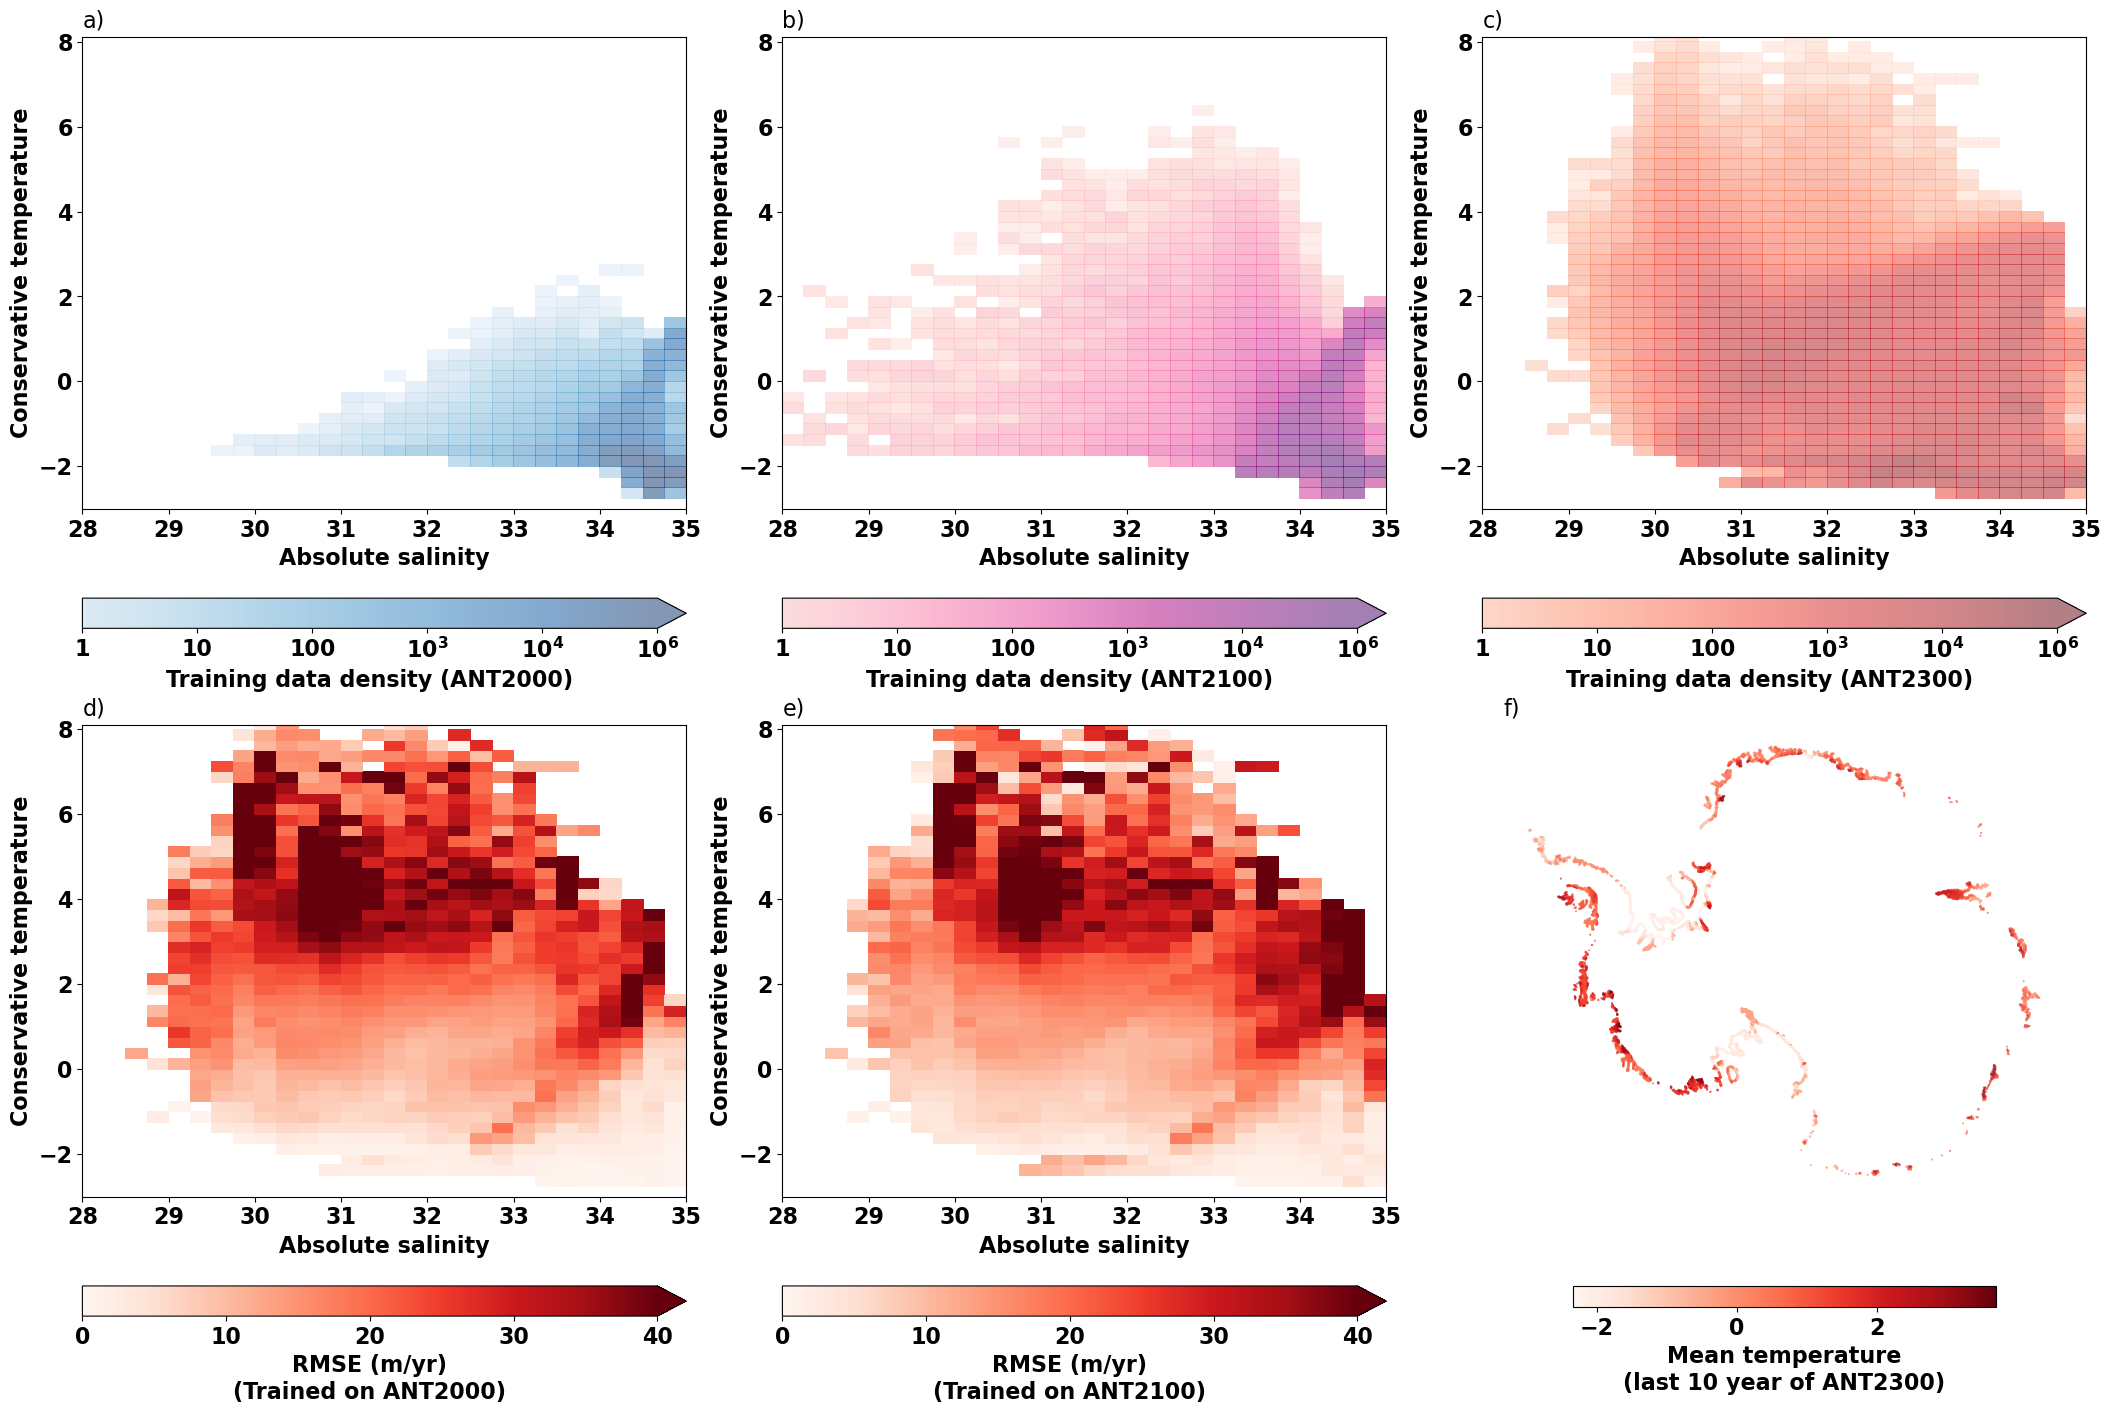

In [38]:
with plt.rc_context({'font.size': 16, 'font.weight': 'bold', 'axes.labelsize': 16, 'axes.labelweight': 'bold'}):
    fig = plt.figure(constrained_layout=True, figsize = (21,14))
    gs = fig.add_gridspec(2,3, width_ratios = (6,6,6), wspace = -1)
    axs = [[],[],[],[],[],[],[],[]]
    axs[0] = fig.add_subplot(gs[0,0])
    axs[1] = fig.add_subplot(gs[0,1])
    axs[2] = fig.add_subplot(gs[0,2])
    axs[3] = fig.add_subplot(gs[1,0])
    axs[4] = fig.add_subplot(gs[1,1])
    axs[5] = fig.add_subplot(gs[1,2], projection = proj)
    gs.update(wspace=0, hspace = 0)
    
    im= [[],[],[]]
    ax = axs[0]
    im[0] = ax.pcolor(sals+0.125, temps+0.125, np.log10(counts_d0), cmap = 'Blues', alpha = 0.5)
    ax = axs[1]
    im[1] = ax.pcolor(sals+0.125, temps+0.125, np.log10(counts_d3), cmap = 'RdPu', alpha = 0.5)
    ax = axs[2]
    im[2] = ax.pcolor(sals+0.125, temps+0.125, np.log10(counts_d2), cmap = 'Reds', alpha = 0.5)

    simulation = '(ANT2000)', '(ANT2100)', '(ANT2300)'
    for i in range(3):
        boundaries = np.linspace(1,6,100)
        cbar = plt.colorbar(im[i], ax=axs[i], boundaries = boundaries, extend = 'max', orientation = 'horizontal', pad = 0.05)
        im[i].set_clim(-1,6)
        cbar.set_ticks((1,2,3,4,5,6))
        cbar.set_ticklabels(('1','10','100', '10$^3$', '10$^4$', '10$^6$'))  
        cbar.set_label('Training data density ' + simulation[i])

    ax = axs[3]
    im3 = ax.pcolor(sals+0.125, temps+0.125, rmse*(31536000/917), cmap = 'Reds', zorder = 0)
    for i in range(5):
        axs[i].set_xlabel('Absolute salinity')
        axs[i].set_ylabel('Conservative temperature')
        axs[i].set_xlim(28,35)
        axs[i].set_ylim(-3,8.1)
    im3.set_clim(0,40)
    cbar = plt.colorbar(im3, ax = ax, label = 'RMSE (m/yr)\n(Trained on ANT2000)', extend = 'max', orientation = 'horizontal', pad = 0.05)
    cbar.set_ticks((0,10,20,30,40))
    cbar.set_ticklabels(('0','10','20','30','40'))

    ax = axs[4]
    im3 = ax.pcolor(sals+0.125, temps+0.125, rmse_Ch*(31536000/917), cmap = 'Reds', zorder = 0)
    for i in range(5):
        axs[i].set_xlabel('Absolute salinity')
        axs[i].set_ylabel('Conservative temperature')
        axs[i].set_xlim(28,35)
        axs[i].set_ylim(-3,8.1)
    im3.set_clim(0,40)
    cbar = plt.colorbar(im3, ax = ax, label = 'RMSE (m/yr)\n(Trained on ANT2100)', extend = 'max', orientation = 'horizontal', pad = 0.05)
    cbar.set_ticks((0,10,20,30,40))
    cbar.set_ticklabels(('0','10','20','30','40'))

    ax = axs[5]
    im = ax.scatter(df2_point.lon, df2_point.lat, c = df2_point.temperature_prop, cmap = 'Reds', transform = trans, s = 0.1)
    cbar = plt.colorbar(im, ax = ax, shrink = 0.7, orientation = 'horizontal', pad = 0.05)
    cbar.set_label('Mean temperature\n(last 10 year of ANT2300)') 
    ax.axis('off')

    plt_labels = 'a)', 'b)', 'c)', 'd)', 'e)', 'f)'
    for i in range(6):
        axs[i].annotate(plt_labels[i], xy = (0,0), xytext = (0,1.02), xycoords = 'axes fraction', fontweight = 'normal')
    
    plt.show()
    fig.savefig(fp_figures + 'F5_TandS_ranges.png', dpi = 200, bbox_inches = 'tight')

## **Figure 6**

In [15]:
df_26on263_trim = pd.read_csv(fp_data+ 'df_26on263_trim.csv')
df_26on263_ym = df_26on263_trim.groupby(['year','month'],as_index = False).sum()

i = 16
mask = np.in1d(df_26on263_trim.basin, regions[i])
bym2 = df_26on263_trim[~mask].groupby(['year'], as_index = False).sum()
   

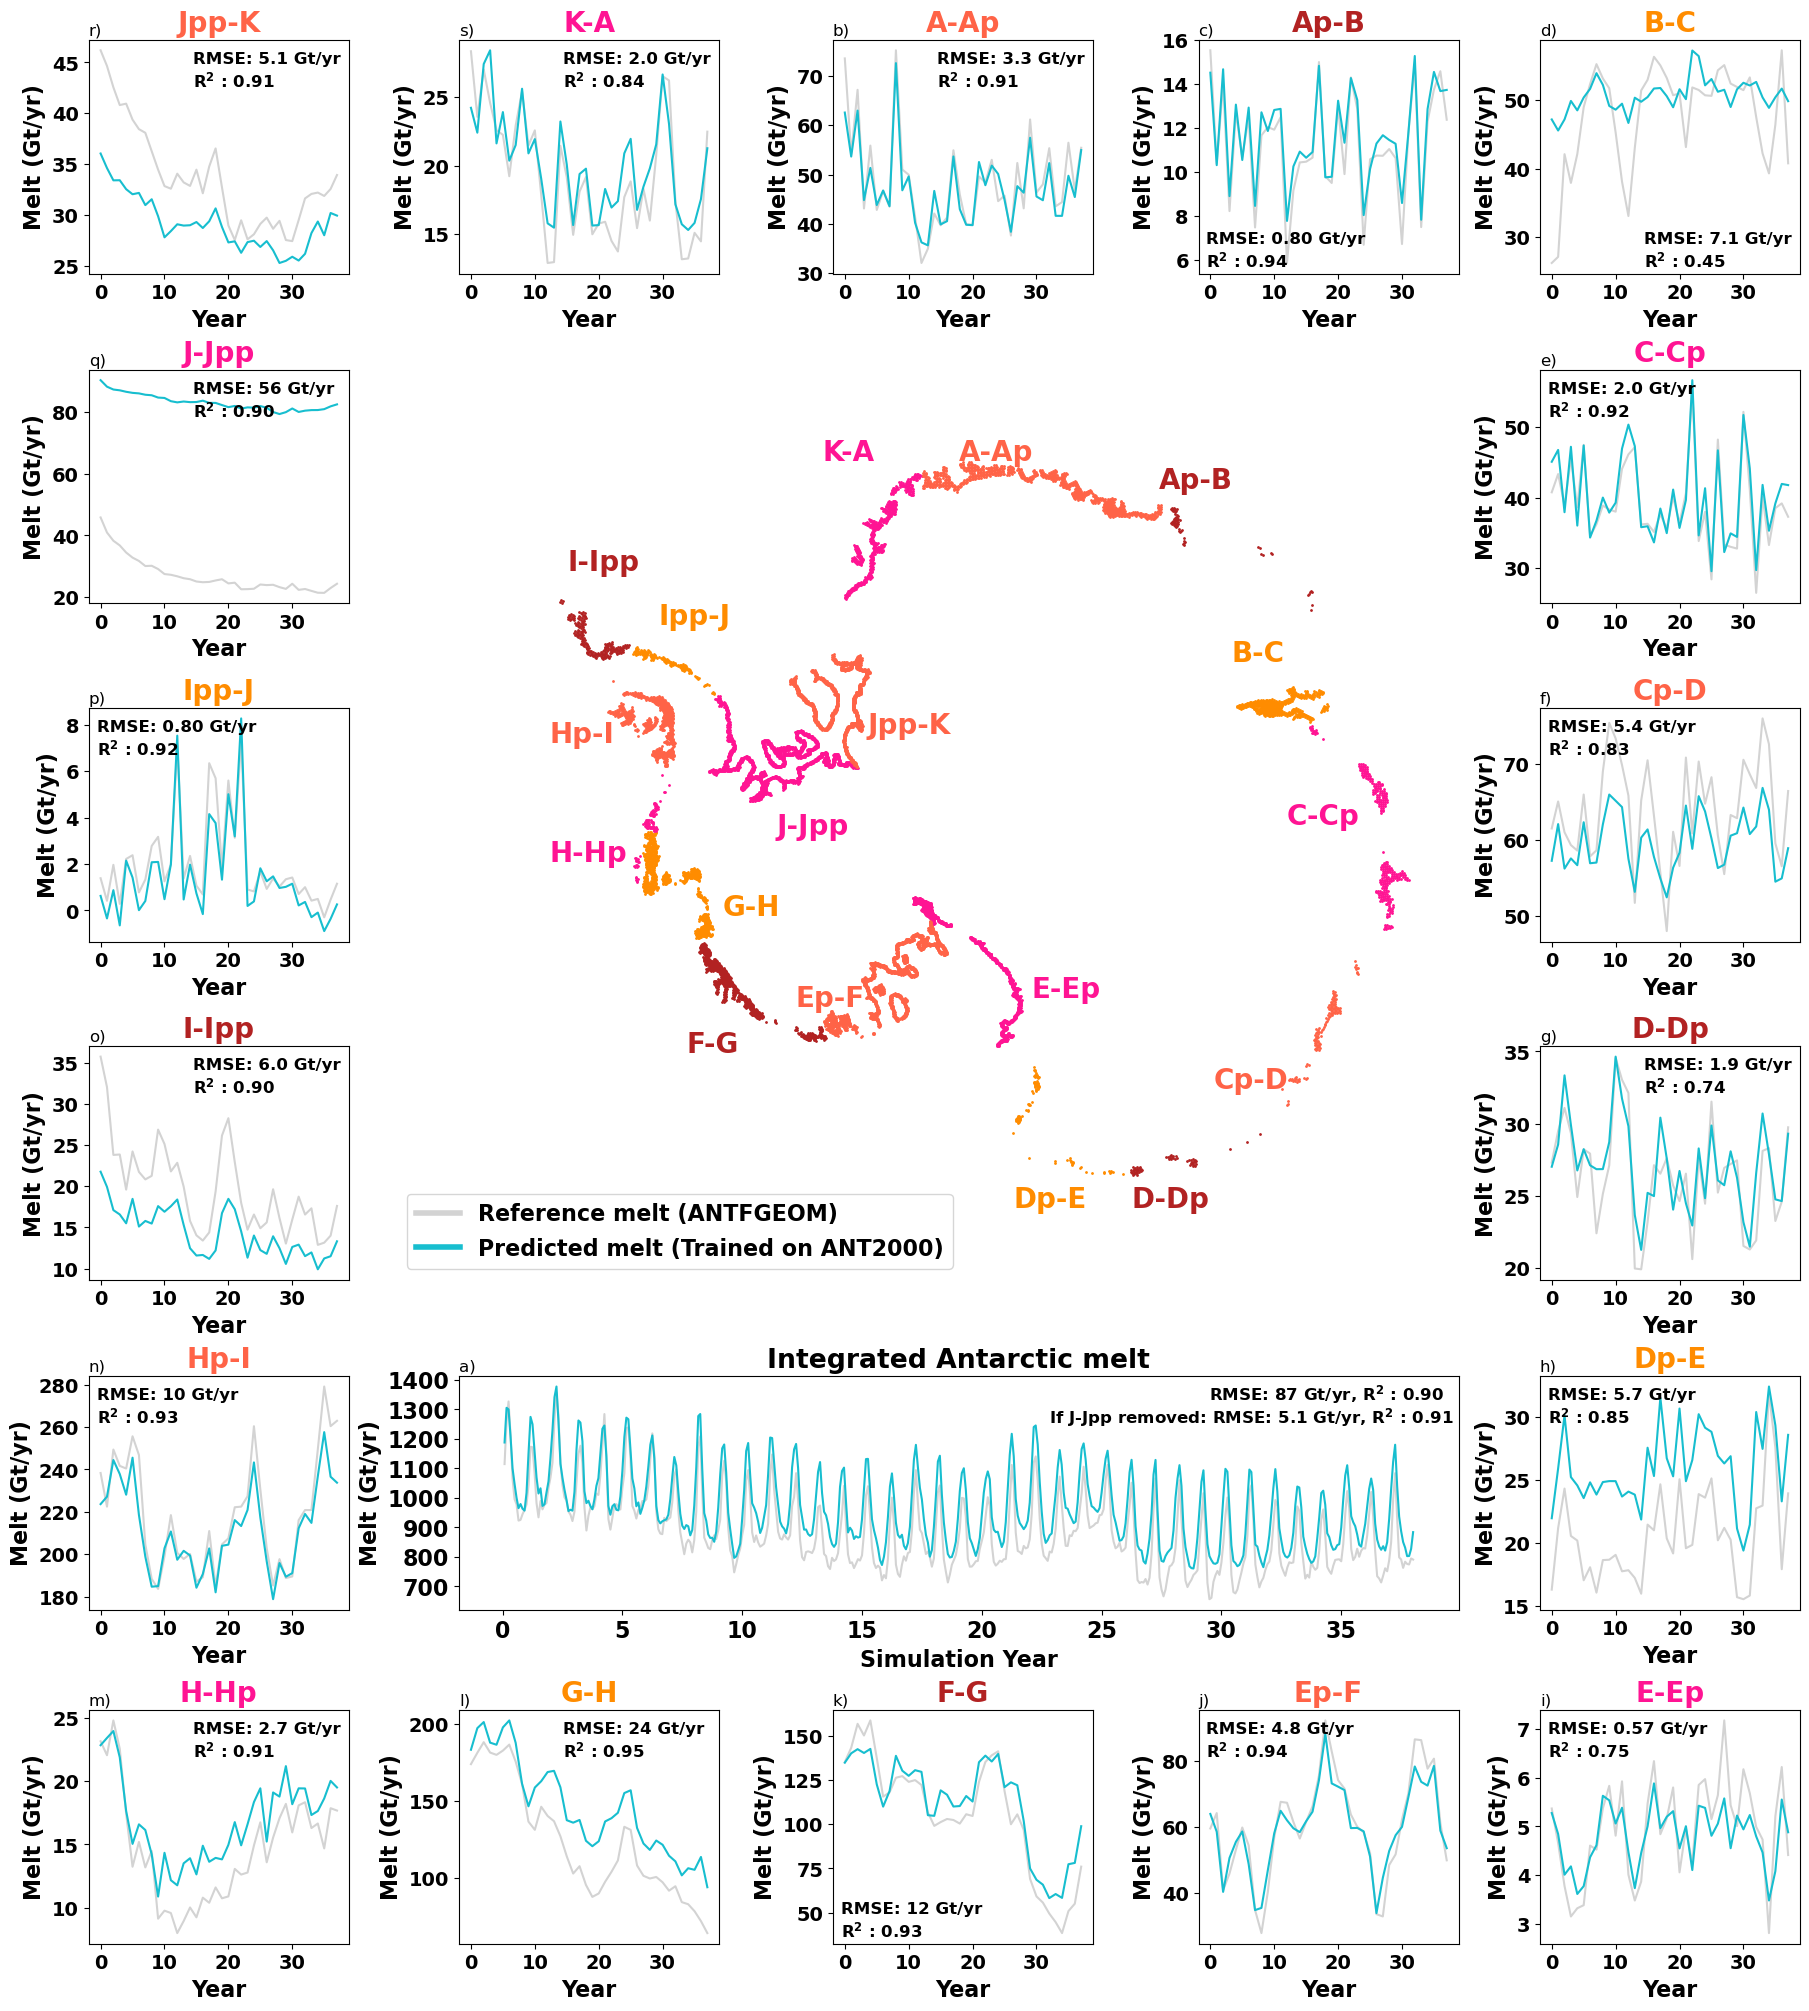

In [16]:
with plt.rc_context({'font.size': 16, 'font.weight': 'bold', 'axes.labelsize': 16, 'axes.labelweight': 'bold'}):
    axs = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
    fig = plt.figure(constrained_layout=True, figsize = (18,20))
    widths = [4,4,4,4,4]
    heights = [4,4,4,4,4,4]
    gs = fig.add_gridspec(6,5, width_ratios = widths, height_ratios = heights)
    #for i,j in itertools.product(range(6),range(5)):
    #    fig.add_subplot(gs[i,j])
    
    axs[17] = fig.add_subplot(gs[1:4,1:4], projection= proj)
    axs[17].set_extent( (-180, 180, -88, -65), trans )
    for i in range(len(regions)):
        for j in range(len(regions[i])):
            basin = latlonbasin[latlonbasin.basin == regions[i][j]]
            im = axs[17].scatter(basin.lon, basin.lat, c = colors[np.mod(i,4)], \
                       transform = trans, s= 1)    
        axs[17].annotate(titles[i], xy = (0,0), xytext = (coords[i]), xycoords = 'axes fraction', transform = trans, \
                       fontsize = 20, color = colors[np.mod(i,4)])
    
    axs[17].axis('off')

    plot_i = [0,0,0,0,1,2,3,4,5,5,5,5,5,4,3,2,1,0]
    plot_j = [1,2,3,4,4,4,4,4,4,3,2,1,0,0,0,0,0,0]
    xytexts = [(0.4,0.8), (0.4,0.8), (0.03,0.03), (0.4,0.03), (0.03,0.8), (0.03,0.8), 
               (0.4,0.8), (0.03,0.8), (0.03,0.8), (0.03,0.8), (0.03,0.03), (0.4,0.8),  
               (0.4,0.8), (0.03,0.8), (0.4,0.8), (0.03,0.8), (0.4,0.8), (0.4,0.8)]
    plt_labels = ['s)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)', 'l)', 'm)', 'n)', 'o)', 'p)', 'q)', 'r)'] 
    for i in range(18):
        axs[i] = fig.add_subplot(gs[plot_i[i], plot_j[i]])

    bym = df_26on263_trim
    for i in range(18):
        mask = np.in1d(bym.basin, regions[i])
        bym2 = bym[mask].groupby(['year'], as_index = False).sum()
        RMSE = np.sqrt(np.mean((bym2.melt_Gt_per_y/12- bym2.melt_pred_Gt/12)**2))
        R2 = regression_analysis(bym2.melt_Gt_per_y,bym2.melt_pred_Gt)[2]
        RMSE = twosigfig(RMSE)
        axs[i].plot(bym2.year-np.min(bym2.year), -bym2.melt_Gt_per_y/12, color = 'lightgrey')
        axs[i].plot(bym2.year-np.min(bym2.year), -bym2.melt_pred_Gt/12, color = 'C9')
        axs[i].set_title(titles[i], fontsize = 20, fontweight = 'bold', color = colors[np.mod(i,4)])
        axs[i].tick_params(axis='both', which='major', labelsize=14)
        axs[i].set_xlabel('Year')
        axs[i].set_ylabel('Melt (Gt/yr)')
        axs[i].set_xticks((0,10,20,30))
        axs[i].annotate('RMSE: {} Gt/yr\nR$^2$ : {:.2f}'.format(RMSE, R2), xytext = xytexts[i], xy = (0,0), \
                        xycoords = 'axes fraction', fontsize = 12)
        label = plt_labels[i]
        axs[i].annotate(label, xytext = (0,1.02), xy = (0,0), \
                        xycoords = 'axes fraction', fontsize = 12, fontweight = 'normal')

    axs[18] = fig.add_subplot(gs[4,1:4])
    axs[18].set_title('Integrated Antarctic melt', fontweight = 'bold')
    axs[18].set_xlabel('Year')
    axs[18].set_ylabel('Melt (Gt/yr)')

    ax=axs[18]

    df_z = df_26on263_ym
    ax.plot(df_z.year-np.min(df_z.year) + df_z.month/12, -df_z.melt_Gt_per_y, color = 'lightgrey', \
            label = 'Reference melt (GEOM)', zorder = 0)
    ax.plot(df_z.year-np.min(df_z.year) + df_z.month/12, -df_z.melt_pred_Gt, color = 'C9', \
            label = 'Predicted melt (Trained on REF)', zorder = 0)
    #ax.fill_between(df_26on263_ym.year + df_26on263_ym.month/12, -df_26on263_ym.melt_pred_Gt - df_26on263_ym.std_Gt/12\
    #                -df_26on263_ym.melt_pred_Gt + df_26on263_ym.std_Gt/12, color = 'C9', alpha = 0.2) 
    ax.set_xlabel('Simulation Year', fontsize = 16)
    ax.set_ylabel('Melt (Gt/yr)', fontsize = 16)
    
    
    RMSE = np.sqrt(np.mean((df_z.melt_Gt_per_y- df_z.melt_pred_Gt)**2))
    R2 = regression_analysis(df_z.melt_Gt_per_y,df_z.melt_pred_Gt)[2]
    RMSE = twosigfig(RMSE)
    ax.annotate('RMSE: {} Gt/yr, R$^2$ : {:.2f}'.format(RMSE, R2), xytext = (0.75,0.9), xy = (0,0), \
                        xycoords = 'axes fraction', fontsize = 12)
    RMSE = np.sqrt(np.mean((bym2.melt_Gt_per_y/12- bym2.melt_pred_Gt/12)**2))
    R2 = regression_analysis(bym2.melt_Gt_per_y,bym2.melt_pred_Gt)[2]
    RMSE = twosigfig(RMSE)
    ax.annotate('If J-Jpp removed: RMSE: {} Gt/yr, R$^2$ : {:.2f}'.format(RMSE, R2), xytext = (0.59,0.8), xy = (0,0), \
                        xycoords = 'axes fraction', fontsize = 12)

    label = 'a)'
    ax.annotate(label, xytext = (0,1.02), xy = (0,0), \
                        xycoords = 'axes fraction', fontsize = 12, fontweight = 'normal')

    axs[19] = fig.add_subplot(gs[3,1:3])
    ax = axs[19]
    ax.plot(df_z.year-np.min(df_z.year) + df_z.month/12, -df_z.melt_Gt_per_y, color = 'lightgrey', \
            label = 'Reference melt (ANTFGEOM)', zorder = 0)
    ax.plot(df_z.year-np.min(df_z.year) + df_z.month/12, -df_z.melt_pred_Gt, color = 'C9', \
            label = 'Predicted melt (Trained on ANT2000)', zorder = 0)
    leg = ax.legend(fontsize = 16, loc = 'lower left', bbox_to_anchor = [-0.1,0,0.8,1])
    for line in leg.get_lines():
        line.set_linewidth(4.0)
    ax.set_xlim(-20,-10)
    ax.axis('off')
   
plt.show()
fig.savefig(fp_figures+ 'F6_Basin_melt_GEOM.png', dpi = 200, bbox_inches = 'tight')

## **Figure 7**

In [17]:
ass = np.loadtxt(fp_data + 'ass.csv', delimiter = ',')
bss = np.loadtxt(fp_data + 'bss.csv', delimiter = ',')
rmse = np.loadtxt(fp_data + 'rmse_geom.csv', delimiter = ',')
df_0_sin = pd.read_csv(fp_data + 'df_0_sin_save.csv')
df_1_sin = pd.read_csv(fp_data + 'df_1_sin_save.csv')

In [18]:
angles = np.linspace(0,360,60)
x = 0.02 * np.cos(angles*np.pi/180)
y = 0.02 * np.sin(angles*np.pi/180)
x15 = 0.015 * np.cos(angles*np.pi/180)
y15 = 0.015 * np.sin(angles*np.pi/180)

nemo_run = 'OPM026'
geom_26 = xr.load_dataset('/bettik/ockendeh/SCRIPTS/simpleNN_basal_melt/AIAI_data/Masks/'+nemo_run+'_geom_vars.nc')
mask_26 = xr.load_dataset('/bettik/ockendeh/SCRIPTS/simpleNN_basal_melt/AIAI_data/Masks/'+nemo_run+'_geometric_masks.nc')

nemo_run = 'OPM0263'
geom_263 = xr.load_dataset('/bettik/ockendeh/SCRIPTS/simpleNN_basal_melt/AIAI_data/Masks/'+nemo_run+'_geom_vars.nc')
mask_263 = xr.load_dataset('/bettik/ockendeh/SCRIPTS/simpleNN_basal_melt/AIAI_data/Masks/'+nemo_run+'_geometric_masks.nc')

/tmp/ipykernel_2521555/3927144172.py:26: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = plt.colorbar(im[1], ax = axs[2], pad = 0.1, label = 'RMSE (m/yr)')


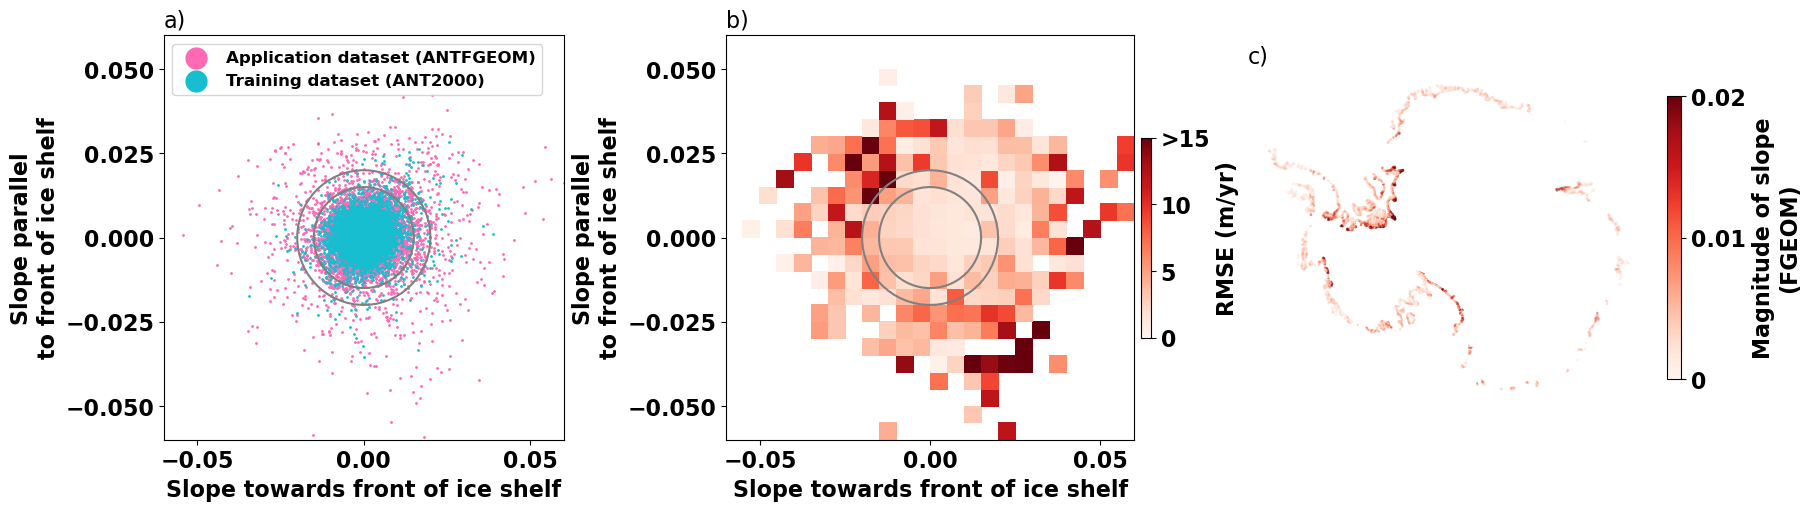

In [19]:
with plt.rc_context({'font.size': 16, 'font.weight': 'bold', 'axes.labelsize': 16, 'axes.labelweight': 'bold'}):

    fig = plt.figure(constrained_layout=True, figsize = (18,5))
    gs = fig.add_gridspec(1,4, width_ratios = (6,5,1,6), wspace = -1)
    axs = [[],[],[],[]]
    axs[0] = fig.add_subplot(gs[0,0])
    axs[1] = fig.add_subplot(gs[0,1:3])
    axs[2] = fig.add_subplot(gs[0,2])
    axs[3] = fig.add_subplot(gs[0,3], projection = proj)
    gs.update(wspace=0, hspace = 0.7)
    axs[0].scatter(df_1_sin.slope_is_across_front, df_1_sin.slope_is_towards_front, s = 1, color = 'hotpink', alpha = 1, \
                       label = 'Application dataset (ANTFGEOM)')
    axs[0].scatter(df_0_sin.slope_is_across_front, df_0_sin.slope_is_towards_front, s = 1, color = 'C9', alpha = 1, \
                  label = 'Training dataset (ANT2000)')
    im = [[],[]]
    im[1] = axs[1].pcolor(ass+0.0025, bss+0.0025, rmse*(31536000/917), cmap = 'Reds', zorder = 0)
    axs[0].legend(loc = 2, markerscale = 15, fontsize = 12)
    for i in range(2):
        axs[i].set_xlabel('Slope towards front of ice shelf')
        axs[i].set_ylabel('Slope parallel\nto front of ice shelf')
        axs[i].set_xticks((-0.05,0,0.05))
        axs[i].set_yticks((-0.05,-0.025,0,0.025, 0.05))
        axs[i].set_xlim(-0.06,0.06)
        axs[i].set_ylim(-0.06,0.06)
    im[1].set_clim(0,15)
    cbar = plt.colorbar(im[1], ax = axs[2], pad = 0.1, label = 'RMSE (m/yr)')
    cbar.set_ticks((0,5,10,15))
    cbar.set_ticklabels(('0','5','10','>15'))
    #axs[0].yaxis.tick_right()
    #axs[0].set_yticklabels(('','','','',''))
    axs[0].set_ylabel('Slope parallel\nto front of ice shelf')
    axs[2].axis('off')
    #axs[0].plot(x,y, color = 'grey')
    axs[1].plot(x,y, color = 'grey')
    axs[0].plot(x,y, color = 'grey', label = 'Magnitude of slope = 0.02')
    axs[1].plot(x15,y15, color = 'grey')
    axs[0].plot(x15,y15, color = 'grey', label = 'Magnitude of slope = 0.015')
    
    
    im = axs[3].scatter(geom_263.lon.values[~np.isnan(mask_263.closed_cavities_nan)], \
                geom_263.lat.values[~np.isnan(mask_263.closed_cavities_nan)], \
                c = np.sqrt((geom_263.slope_is_across_front**2)+(geom_263.slope_is_towards_front**2)).values[~np.isnan(mask_263.closed_cavities_nan)], cmap = 'Reds',\
               transform = trans, s = 0.01)
    im.set_clim(0,0.02)
    #im.set_clim(0.0,None)
    cbar = plt.colorbar(im, shrink = 0.7)
    cbar.set_label('Magnitude of slope\n(FGEOM)') 
    cbar.set_ticks((0,0.01,0.02))
    cbar.set_ticklabels(('0','0.01','0.02'))
    axs[3].axis('off')

    plt_labels = 'a)', 'b)', 'c)', 'c)'
    for i in (0,1,3):
        axs[i].annotate(plt_labels[i], xy = (0,0), xytext = (0,1.02), xycoords = 'axes fraction', fontweight = 'normal')

    plt.show()
    fig.savefig(fp_figures +'F7_Bigslopes.png', dpi = 200, bbox_inches = 'tight')

## **Figure 8**

**Neural network performance (RMSE) as a function of training data quantity.** 
The RMSE of the integrated reference melt from the ANT2100 simulation when compared to the predicted melt 
from neural networks trained with different volumes of data from the ANT2300 simulation. Results are shown 
when the selected data is either from the beginning of the ANT2300 simulation (light blue, a and b), both 
the beginning and end of the ANT2300 simulation (gray, a and b), or the end of the ANT2300 simulation 
(dark blue, a only). The RMSE of the predicted melt from the neural network trained on the ANT2100 simulation 
and applied to the ANT2100 simulation is also shown in grey (67.5 Gt/yr) as a comparison. 

In [20]:
years = (2,10,20,40,60,80,100)
RMSE_start = np.loadtxt(fp_data + 'RMSE_start.csv', delimiter = ',')
RMSE_mid = np.loadtxt(fp_data + 'RMSE_mid.csv', delimiter = ',')
RMSE_end = np.loadtxt(fp_data + 'RMSE_end.csv', delimiter = ',')
RMSE_ideal = np.loadtxt(fp_data + 'RMSE_ideal.csv', delimiter = ',')

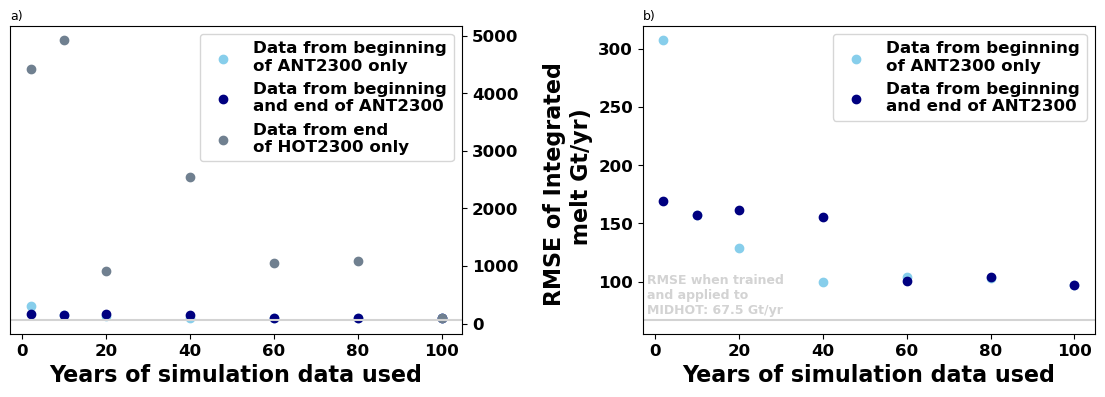

In [21]:
with plt.rc_context({'font.size': 12, 'font.weight': 'bold', 'axes.labelsize': 16, 'axes.labelweight': 'bold'}):
    fig, axs = plt.subplots(1,2, figsize = (14,4))
    plt.subplots_adjust(wspace = 0.4)
    plt_labels = 'a)', 'b)'
    color1 = 'skyblue'
    color2 = 'navy'
    color3 = 'slategray'
    for i in range(2):
        ax = axs[i]
        ax.scatter(years, RMSE_start, color = color1, label = 'Data from beginning\nof ANT2300 only')
        ax.scatter(years, RMSE_mid, color = color2, label = 'Data from beginning\nand end of ANT2300')
        ax.axhline(y = RMSE_ideal[0], color = 'lightgrey')
        ax.set_xlabel('Years of simulation data used')
        ax.annotate(plt_labels[i], xy = (0,0), xytext = (0,1.02), xycoords = 'axes fraction', fontweight = 'normal', fontsize = 9)
    ax = axs[0]    
    ax.scatter(years, RMSE_end, color = color3, label = 'Data from end\nof HOT2300 only')
    axs[1].set_ylabel('RMSE of Integrated \n melt Gt/yr)')
    axs[0].yaxis.tick_right()
    axs[1].annotate('RMSE when trained\nand applied to\nMIDHOT: {:.1f} Gt/yr'.format(RMSE_ideal[0]), xy = (0,0), xytext = (0.01,0.065), \
                    xycoords = 'axes fraction', fontsize = 9, color = 'lightgrey')
    axs[0].legend()        
    axs[1].legend()        
    
    fig.savefig(fp_figures + 'F8_Howmuchdata.pdf', dpi = 200, bbox_inches = 'tight')
    #ax.set_ylim(0,50)
    plt.show()

## **Figure A1**

**The difference in geometries between the ANT2000 simulation and the ANTFGEOM simulation.** The ANT2000 simulation
uses the Bedmachine v2 (Morlighem et al., 2020) geometry, and the ANTFGEOM simulation is mostly identifical but has ice shelf draft is
artificially thinned in the Amundsen Sea (a) and the Filchner-Ronne Ice Shelf (b) regions following the MISOMIP2 protocol (De Rydt et al.,
2024). Figure reproduced from De Rydt et al. (2024).

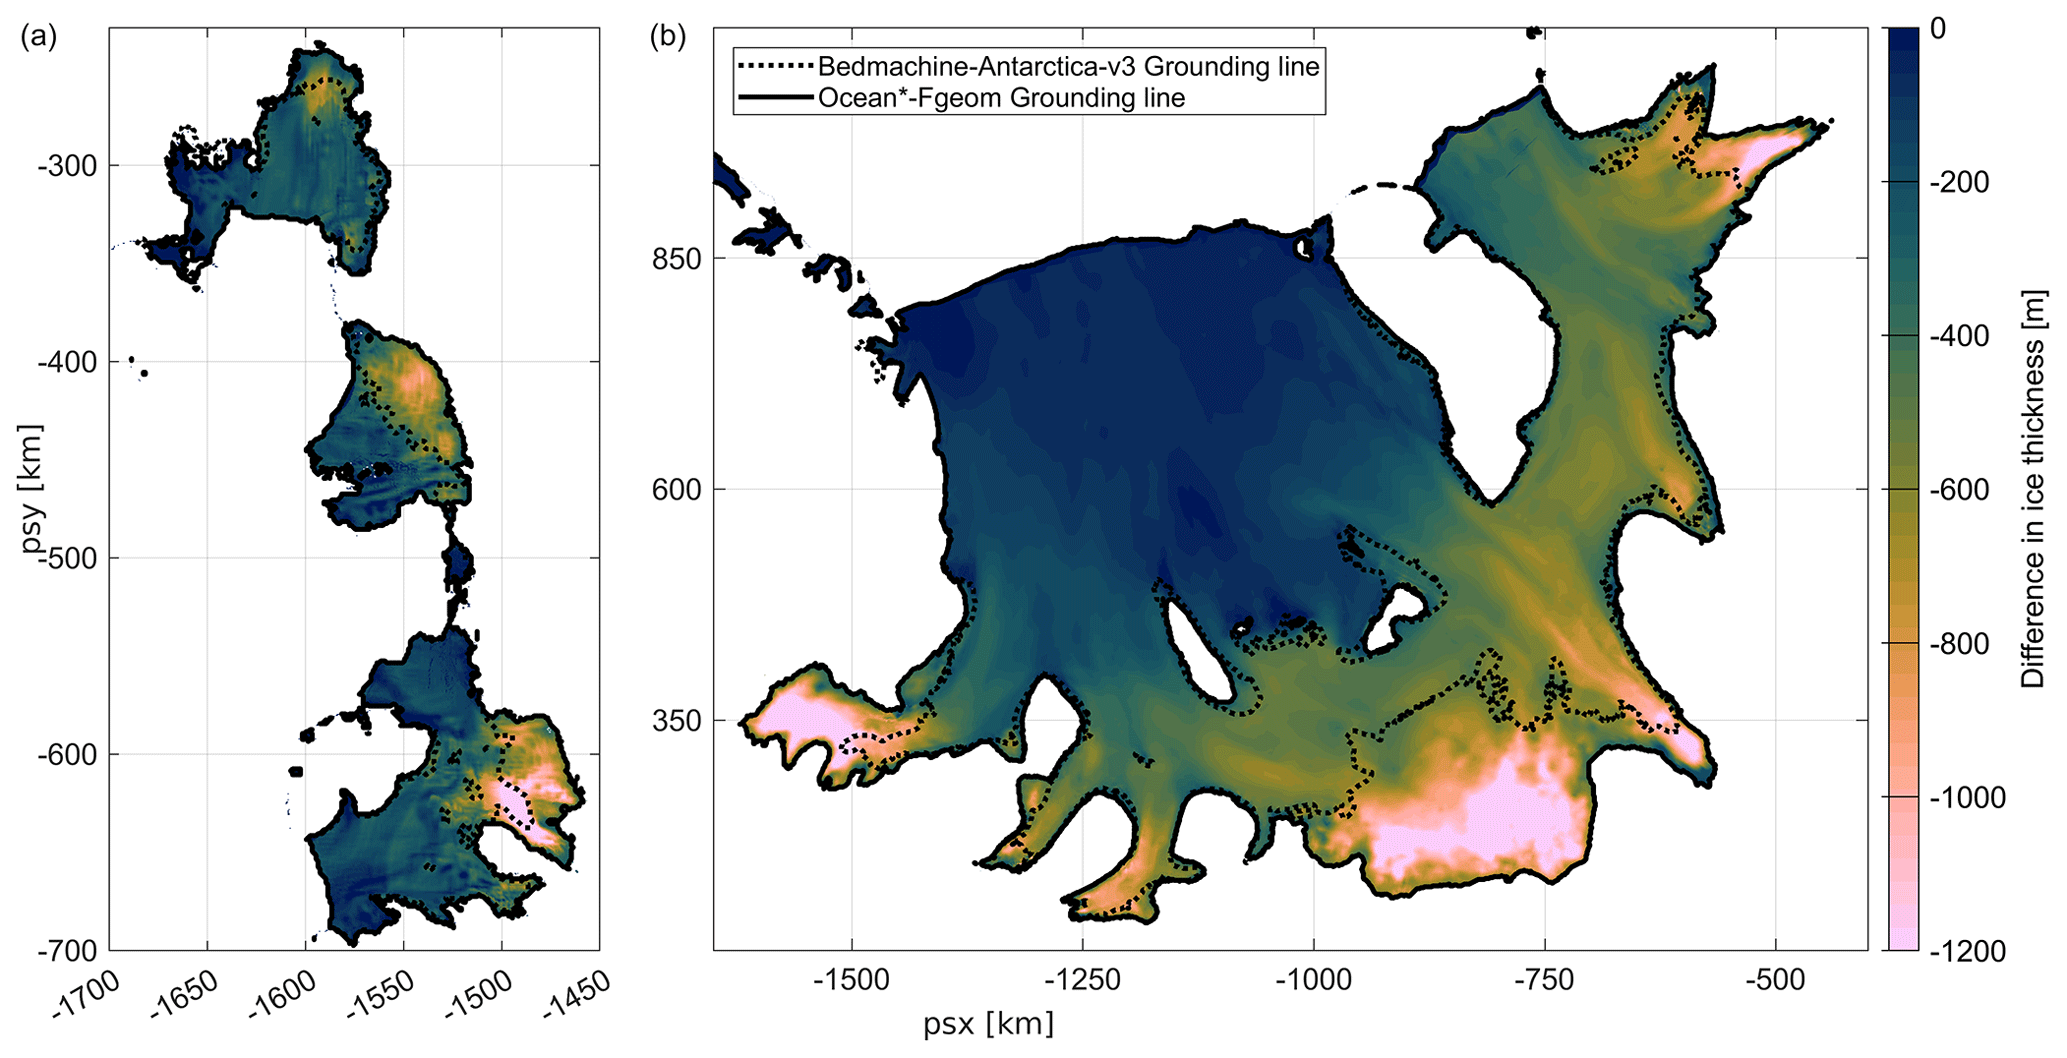

In [22]:
from IPython.display import Image
Image(fp_data + 'FGEOM.png')

## **Figure A2**

**Should neural networks be trained with monthly or annual data?** The results of applying neural networks trained on both
annual and monthly data from ANT2000, ANT2100 and ANT2300 to a) the ANT2100 simulation and b) the ANT2300 simulation, respec-
tively. The reference melt rate for each simulation is show in grey. For all neural network predictions, the root-mean-square error (RMSE) in
Gt/yr and correlation coefficient (R2) are given in the legend. The mean of the standard deviation of the ten ensemble members is given at
the right hand side of the plot, in Gt/yr. The standard deviation gives an idea of the variability in neural networks due to stochastic processes during the training, and higher values indicate that the parameter space is not well constrained by this ensemble.

In [23]:
df_ANT2100 = pd.read_csv(fp_data+ 'df_ANT2100.csv')
df_ANT2300 = pd.read_csv(fp_data+ 'df_ANT2300.csv')

In [24]:
def std_range(melt, std, color, position, total, ax):
    fraction = (-1/(2*total))+(position/total)
    ax.scatter(fraction, melt[-1], color = color)
    ax.plot((fraction,fraction), \
           (melt[-1]+ std[0], melt[-1] - std[0]), 
           color = color)
    ax.annotate('{:.0f} Gt/yr'.format(std[0]), xytext = (fraction,0.2), xy = (0.5,0.5), xycoords = 'axes fraction', \
                rotation = 90, fontsize = 12, color = color)

(697.9596674955063, 2942.846982594366)
(391.3935629939098, 9380.735177127894)


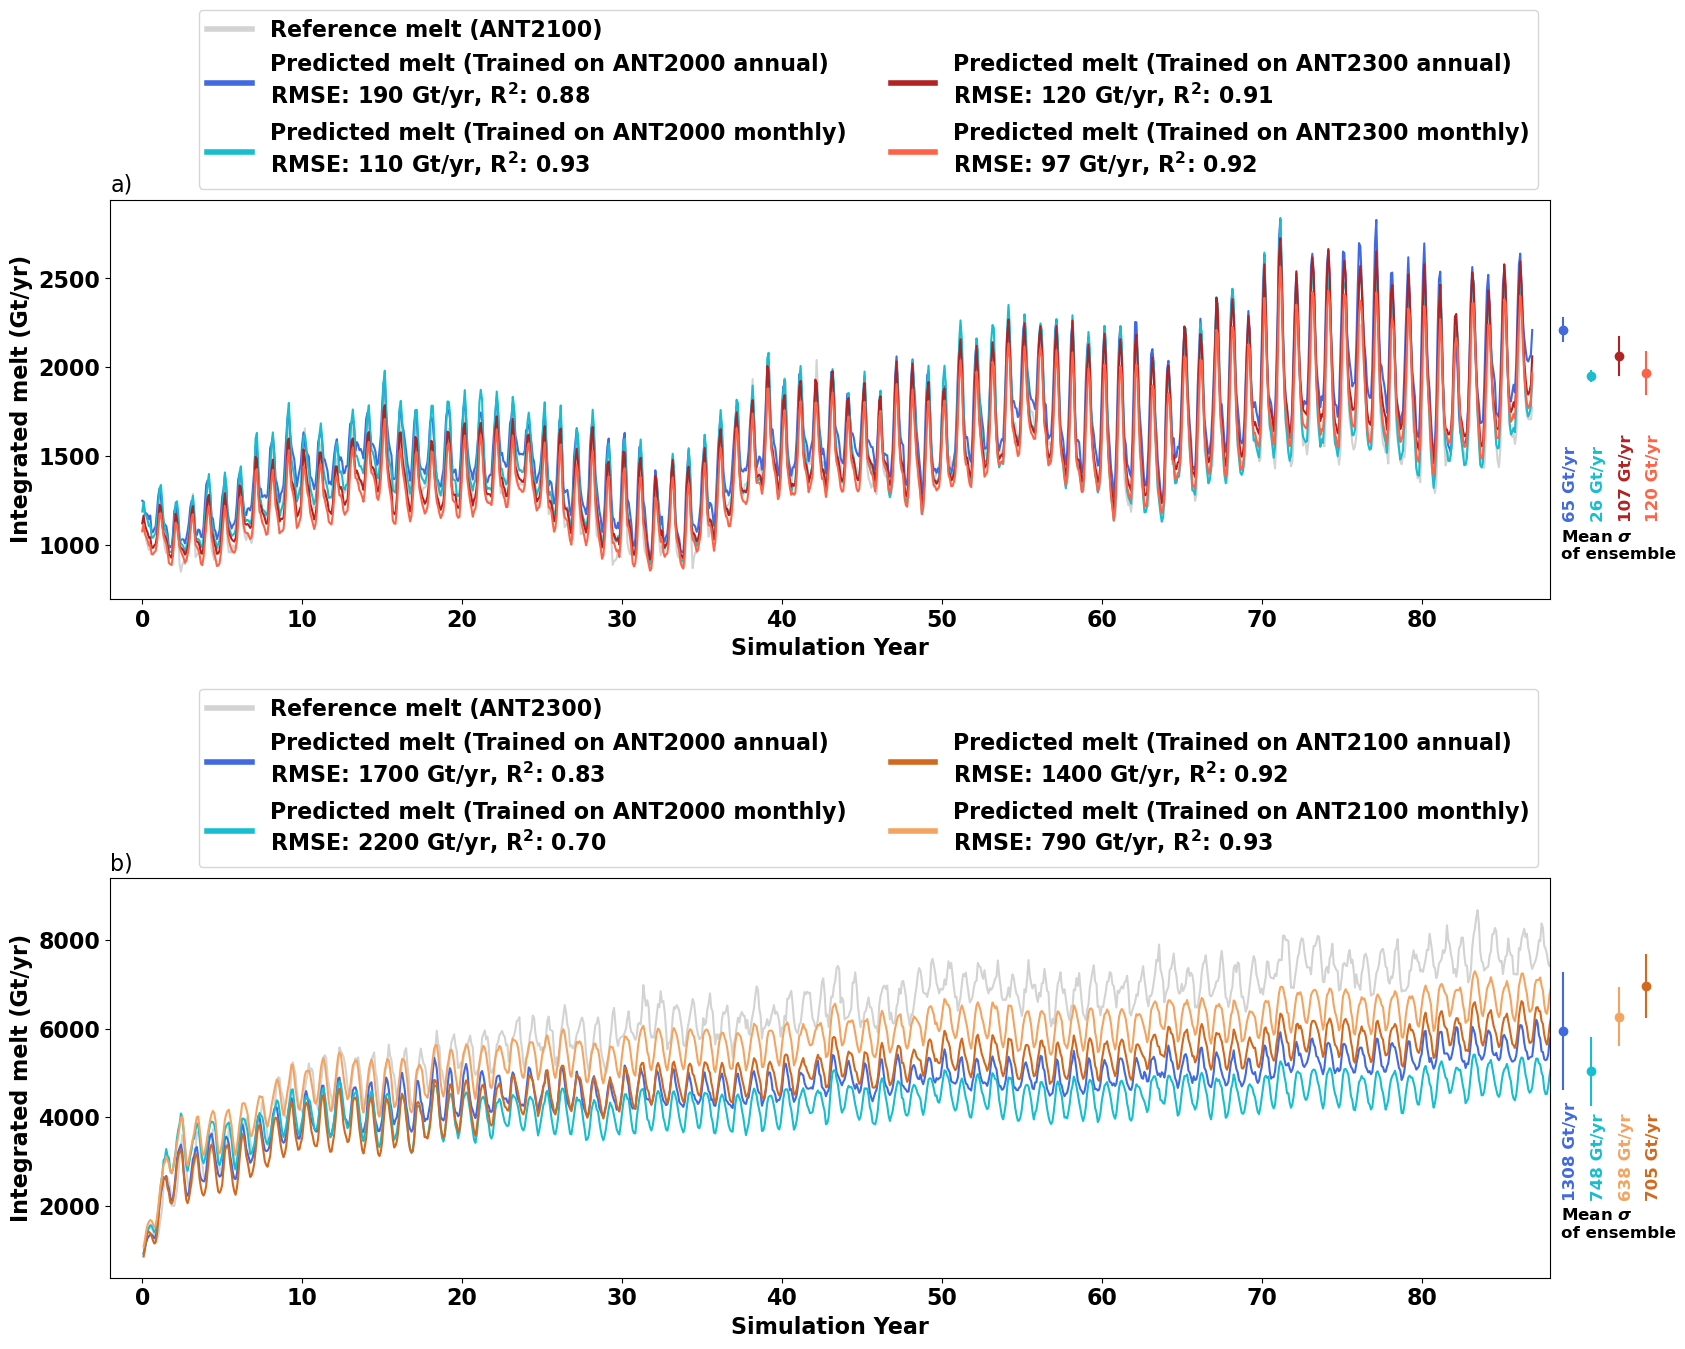

In [25]:
with plt.rc_context({'font.size': 16, 'font.weight': 'bold', 'axes.labelsize': 16, 'axes.labelweight': 'bold'}):
    fig, axs = plt.subplots(2,2, figsize = (20,14), width_ratios = (19.5,1.5))
    fig.subplots_adjust(wspace=0, hspace = 0.7)

    ax = axs[0,0]
    ax.plot(df_ANT2100.year + df_ANT2100.month/12, df_ANT2100.melt_m_ice_per_y, color = 'lightgrey', \
           label = 'Reference melt (ANT2100)')
    RMSE = twosigfig(np.sqrt(np.mean((df_ANT2100.melt_m_ice_per_y - df_ANT2100.melt_an26)**2)))
    R2 = twosigfig(regression_analysis(df_ANT2100.melt_m_ice_per_y, df_ANT2100.melt_an26)[2])
    ax.plot(df_ANT2100.year + df_ANT2100.month/12, df_ANT2100.melt_an26, color = 'royalblue', \
           label = 'Predicted melt (Trained on ANT2000 annual)\nRMSE: {} Gt/yr, R$^2$: {}'.format(RMSE, R2))
    RMSE = twosigfig(np.sqrt(np.mean((df_ANT2100.melt_m_ice_per_y - df_ANT2100.melt_mn26)**2)))
    R2 = twosigfig(regression_analysis(df_ANT2100.melt_m_ice_per_y, df_ANT2100.melt_mn26)[2])
    ax.plot(df_ANT2100.year + df_ANT2100.month/12, df_ANT2100.melt_mn26, color = 'C9', \
           label = 'Predicted melt (Trained on ANT2000 monthly)\nRMSE: {} Gt/yr, R$^2$: {}'.format(RMSE, R2))
    ax.scatter((1), (800), color = 'white', \
               label = " ")
    RMSE = twosigfig(np.sqrt(np.mean((df_ANT2100.melt_m_ice_per_y - df_ANT2100.melt_an31)**2)))
    R2 = twosigfig(regression_analysis(df_ANT2100.melt_m_ice_per_y, df_ANT2100.melt_an31)[2])
    ax.plot(df_ANT2100.year + df_ANT2100.month/12, df_ANT2100.melt_an31, color = 'firebrick', \
           label = 'Predicted melt (Trained on ANT2300 annual)\nRMSE: {} Gt/yr, R$^2$: {}'.format(RMSE, R2))
    RMSE = twosigfig(np.sqrt(np.mean((df_ANT2100.melt_m_ice_per_y - df_ANT2100.melt_mn31)**2)))
    R2 = twosigfig(regression_analysis(df_ANT2100.melt_m_ice_per_y, df_ANT2100.melt_mn31)[2])
    ax.plot(df_ANT2100.year + df_ANT2100.month/12, df_ANT2100.melt_mn31, color = 'tomato', \
           label = 'Predicted melt (Trained on ANT2300 monthly)\nRMSE: {} Gt/yr, R$^2$: {}'.format(RMSE, R2))

    ax.set_xlabel('Simulation Year', fontsize = 16)
    ax.set_ylabel('Integrated melt (Gt/yr)', fontsize = 16)
    ax.set_xlim(-2, np.max(df_ANT2100.year)+2)
    leg = ax.legend(fontsize = 16, loc = 'lower right', bbox_to_anchor = [0,1,1,2], ncols = 2)
    for line in leg.get_lines():
        line.set_linewidth(4.0)
    ylims = ax.get_ylim()
    print(ylims)

    ax = axs[0,1]
    ax.axis('off')
    std_range(df_ANT2100.melt_mn26.values, df_ANT2100.std_mn26, 'C9', 2, 4, ax=ax)
    std_range(df_ANT2100.melt_an26.values, df_ANT2100.std_an26, 'royalblue', 1,4,ax=ax)
    std_range(df_ANT2100.melt_mn31.values, df_ANT2100.std_mn31, 'tomato', 4, 4, ax = ax)
    std_range(df_ANT2100.melt_an31.values, df_ANT2100.std_an31, 'firebrick', 3, 4, ax =ax)
    ax.set_ylim(ylims)
    ax.set_xlim(0,1)

    ax.annotate('Mean $\\sigma$\nof ensemble'.format(np.mean(df_z.std_Gt)), xytext = (0.1,0.1), \
                xy = (0.5,0.5), xycoords = 'axes fraction', \
                fontsize = 12)

    ax = axs[1,0]
    ax.plot(df_ANT2300.year + df_ANT2300.month/12, df_ANT2300.melt_m_ice_per_y, color = 'lightgrey', \
           label = 'Reference melt (ANT2300)')
    RMSE = twosigfig(np.sqrt(np.mean((df_ANT2300.melt_m_ice_per_y - df_ANT2300.melt_an26)**2)))
    R2 = twosigfig(regression_analysis(df_ANT2300.melt_m_ice_per_y, df_ANT2300.melt_an26)[2])
    ax.plot(df_ANT2300.year + df_ANT2300.month/12, df_ANT2300.melt_an26, color = 'royalblue', \
           label = 'Predicted melt (Trained on ANT2000 annual)\nRMSE: {} Gt/yr, R$^2$: {}'.format(RMSE, R2))
    RMSE = twosigfig(np.sqrt(np.mean((df_ANT2300.melt_m_ice_per_y - df_ANT2300.melt_mn26)**2)))
    R2 = twosigfig(regression_analysis(df_ANT2300.melt_m_ice_per_y, df_ANT2300.melt_mn26)[2])
    ax.plot(df_ANT2300.year + df_ANT2300.month/12, df_ANT2300.melt_mn26, color = 'C9', \
           label = 'Predicted melt (Trained on ANT2000 monthly)\nRMSE: {} Gt/yr, R$^2$: {}'.format(RMSE, R2))
    ax.scatter((1), (800), color = 'white', \
               label = " ")
    RMSE = twosigfig(np.sqrt(np.mean((df_ANT2300.melt_m_ice_per_y - df_ANT2300.melt_anc)**2)))
    R2 = twosigfig(regression_analysis(df_ANT2300.melt_m_ice_per_y, df_ANT2300.melt_anc)[2])
    ax.plot(df_ANT2300.year + df_ANT2300.month/12, df_ANT2300.melt_anc, color = 'chocolate', \
           label = 'Predicted melt (Trained on ANT2100 annual)\nRMSE: {} Gt/yr, R$^2$: {}'.format(RMSE, R2))
    RMSE = twosigfig(np.sqrt(np.mean((df_ANT2300.melt_m_ice_per_y - df_ANT2300.melt_mnc)**2)))
    R2 = twosigfig(regression_analysis(df_ANT2300.melt_m_ice_per_y, df_ANT2300.melt_mnc)[2])
    ax.plot(df_ANT2300.year + df_ANT2300.month/12, df_ANT2300.melt_mnc, color = 'sandybrown', \
           label = 'Predicted melt (Trained on ANT2100 monthly)\nRMSE: {} Gt/yr, R$^2$: {}'.format(RMSE, R2))

    ax.set_xlabel('Simulation Year', fontsize = 16)
    ax.set_ylabel('Integrated melt (Gt/yr)', fontsize = 16)
    ax.set_xlim(-2, np.max(df_ANT2100.year)+2)
    leg = ax.legend(fontsize = 16, loc = 'lower right', bbox_to_anchor = [0,1,1,2], ncols = 2)
    for line in leg.get_lines():
        line.set_linewidth(4.0)
    ylims = ax.get_ylim()
    print(ylims)

    ax = axs[1,1]
    ax.axis('off')
    std_range(df_ANT2300.melt_mn26.values, df_ANT2300.std_mn26, 'C9', 2, 4, ax=ax)
    std_range(df_ANT2300.melt_an26.values, df_ANT2300.std_an26, 'royalblue', 1,4,ax=ax)
    std_range(df_ANT2300.melt_mnc.values, df_ANT2300.std_mnc, 'chocolate', 4, 4, ax = ax)
    std_range(df_ANT2300.melt_anc.values, df_ANT2300.std_anc, 'sandybrown', 3, 4, ax =ax)
    ax.set_ylim(ylims)
    ax.set_xlim(0,1)
    ax.annotate('Mean $\\sigma$\nof ensemble'.format(np.mean(df_z.std_Gt)), xytext = (0.1,0.1), \
                xy = (0.5,0.5), xycoords = 'axes fraction', \
                fontsize = 12)

    labels = ('a)', 'b)')
    for i in range(2):
        axs[i,0].annotate(labels[i], xytext = (0,1.02), \
                xy = (0.5,0.5), xycoords = 'axes fraction', fontweight = 'normal')

    plt.show()
    fig.savefig(fp_figures +'FA1_Monthly_or_Annual.pdf', bbox_inches = 'tight')